In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from glob import iglob
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns

In [2]:
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['legend.markerscale'] = 2
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.dpi'] = 100

sns.set_style('ticks')
sns.set_palette('Set1')

# Look at some basic qc information about the experiments

In [3]:
qcs = iglob('mSp_scATAC-seq/qc_metrics/*.txt')

dfs = []
for qc in qcs:
    dfs.append(pd.read_table(qc, index_col=0))

plate_qc = pd.concat(dfs, axis=1, sort=False)
plate_qc['plate'] = plate_qc.index.str.extract('mSp_(.*)_.*', expand=False)

# two batches (biological replicates)
# rep1 to rep4 are from one mouse
# rep5 to rep11 are from another mouse
batches = {}
for i in range(1,5):
    batches['rep{}'.format(i)] = 'Sp#1 (n=960)'
for i in range(5,12):
    batches['rep{}'.format(i)] = 'Sp#2 (n=2688)'

plate_qc['batch'] = plate_qc.plate.replace(batches) 

sort_idx = plate_qc.index.sort_values()
plate_qc =  plate_qc.loc[sort_idx]

plate_qc.head()

dup_level  frac_open      frip  library_size  mapping_rate  \
mSp_rep10_001   0.946339   0.177978  0.726419       34986.0         97.05   
mSp_rep10_002   0.949220   0.216714  0.670139       48428.0         96.44   
mSp_rep10_003   0.949138   0.124075  0.744450       21665.0         96.63   
mSp_rep10_004   0.947677   0.178362  0.682887       34349.0         96.82   
mSp_rep10_005   0.945384   0.204391  0.668207       44350.0         97.06   

               mt_content  sequencing_depth  uniq_frags  plate          batch  
mSp_rep10_001    0.008089            706791     34703.0  rep10  Sp#2 (n=2688)  
mSp_rep10_002    0.021640           1055503     47380.0  rep10  Sp#2 (n=2688)  
mSp_rep10_003    0.005031            464232     21556.0  rep10  Sp#2 (n=2688)  
mSp_rep10_004    0.017701            719629     33741.0  rep10  Sp#2 (n=2688)  
mSp_rep10_005    0.011364            879974     43846.0  rep10  Sp#2 (n=2688)

In [4]:
plate_qc.median()

dup_level                0.946167
frac_open                0.166699
frip                     0.724165
library_size         31808.500000
mapping_rate            97.050000
mt_content               0.018261
sequencing_depth    643734.000000
uniq_frags           30727.000000
dtype: float64

In [5]:
plate_qc.groupby('plate').median()

dup_level  frac_open      frip  library_size  mapping_rate  mt_content  \
plate                                                                           
rep1    0.953395   0.149041  0.739804       26791.0        97.310    0.024070   
rep10   0.944155   0.167512  0.732649       31195.0        96.890    0.018710   
rep11   0.949515   0.177395  0.720001       34003.0        97.300    0.016635   
rep2    0.972433   0.159602  0.719500       29472.5        97.225    0.020952   
rep3    0.957338   0.163740  0.716885       31172.0        97.100    0.020108   
rep4    0.954211   0.163137  0.727318       30703.5        97.170    0.020314   
rep5    0.940420   0.174243  0.714813       33006.0        97.335    0.015515   
rep6    0.955234   0.124305  0.723693       30858.0        96.320    0.021978   
rep7    0.947172   0.159704  0.734233       31653.0        96.840    0.018501   
rep8    0.939764   0.177056  0.714086       33969.0        97.350    0.015502   
rep9    0.941794   0.166981  0.731391       31524.5        96.980    0.018378   

       sequencing_depth  uniq_frags  
plate                                
rep1           613945.5     26334.5  
rep10          613522.0     30715.5  
rep11          721892.5     33503.0  
rep2          1143367.5     29019.5  
rep3           771192.0     30389.0  
rep4           719885.5     30139.0  
rep5           593435.5     32436.0  
rep6           539171.5     20976.5  
rep7           616298.0     29098.5  
rep8           596865.0     33429.5  
rep9           583688.5     30671.5

In [6]:
plate_qc.groupby('batch').median()

dup_level  frac_open      frip  library_size  mapping_rate  \
batch                                                                       
Sp#1 (n=960)    0.956036   0.161069  0.724785       30402.0         97.16   
Sp#2 (n=2688)   0.943526   0.168569  0.724142       32292.0         97.01   

               mt_content  sequencing_depth  uniq_frags  
batch                                                    
Sp#1 (n=960)     0.020665            745627     29679.5  
Sp#2 (n=2688)    0.017594            614981     31193.0

In [7]:
empty_cells = ['mSp_rep1_096', 'mSp_rep2_096',
               'mSp_rep3_366', 'mSp_rep3_372', 'mSp_rep3_378', 'mSp_rep3_384',
               'mSp_rep4_366', 'mSp_rep4_372', 'mSp_rep4_378', 'mSp_rep4_384']
empty_cells.extend(['mSp_rep{}_384'.format(i) for i in range(5,12)])

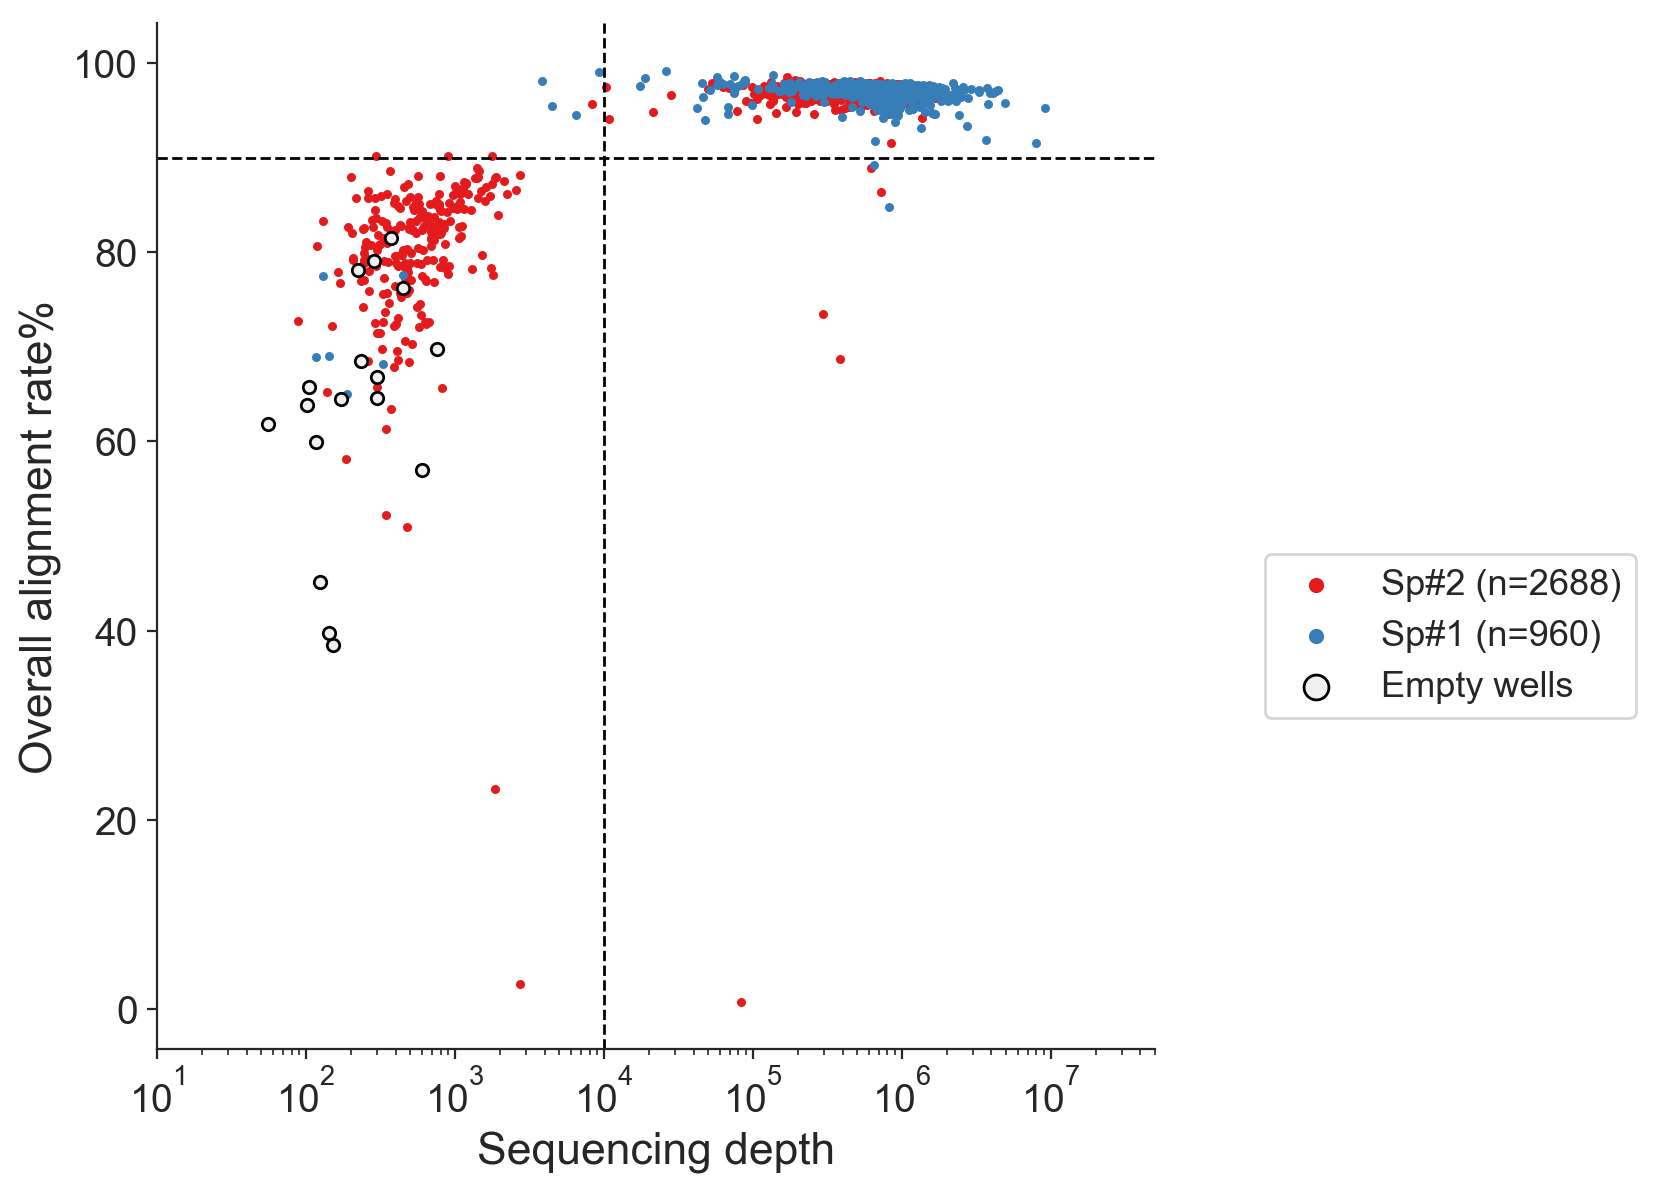

In [8]:
g = sns.FacetGrid(plate_qc.drop(labels=empty_cells), hue='batch', height=6)
g.map(plt.scatter, 'sequencing_depth', 'mapping_rate', s=5, rasterized=True)
g.ax.set_xscale('log')
g.ax.set_xlim(10, 5e7)

g.ax.scatter(plate_qc.loc[empty_cells, 'sequencing_depth'],
             plate_qc.loc[empty_cells, 'mapping_rate'],
             label='Empty wells', c='#f0f0f0',
             s=20, edgecolors='k')

g.ax.legend(bbox_to_anchor=[1.5, .5])
g.ax.axhline(y=90, xmin=0, xmax=1, ls='dashed', c='k', lw=1.)
g.ax.axvline(x=1e4, ymin=0, ymax=1, ls='dashed', c='k', lw=1.)

g.ax.set_xlabel('Sequencing depth')
g.ax.set_ylabel('Overall alignment rate%')

plt.savefig('figures/qc_sequencing_depth_vs_mapping_rate.pdf',
            bbox_inches='tight', transparent=True)

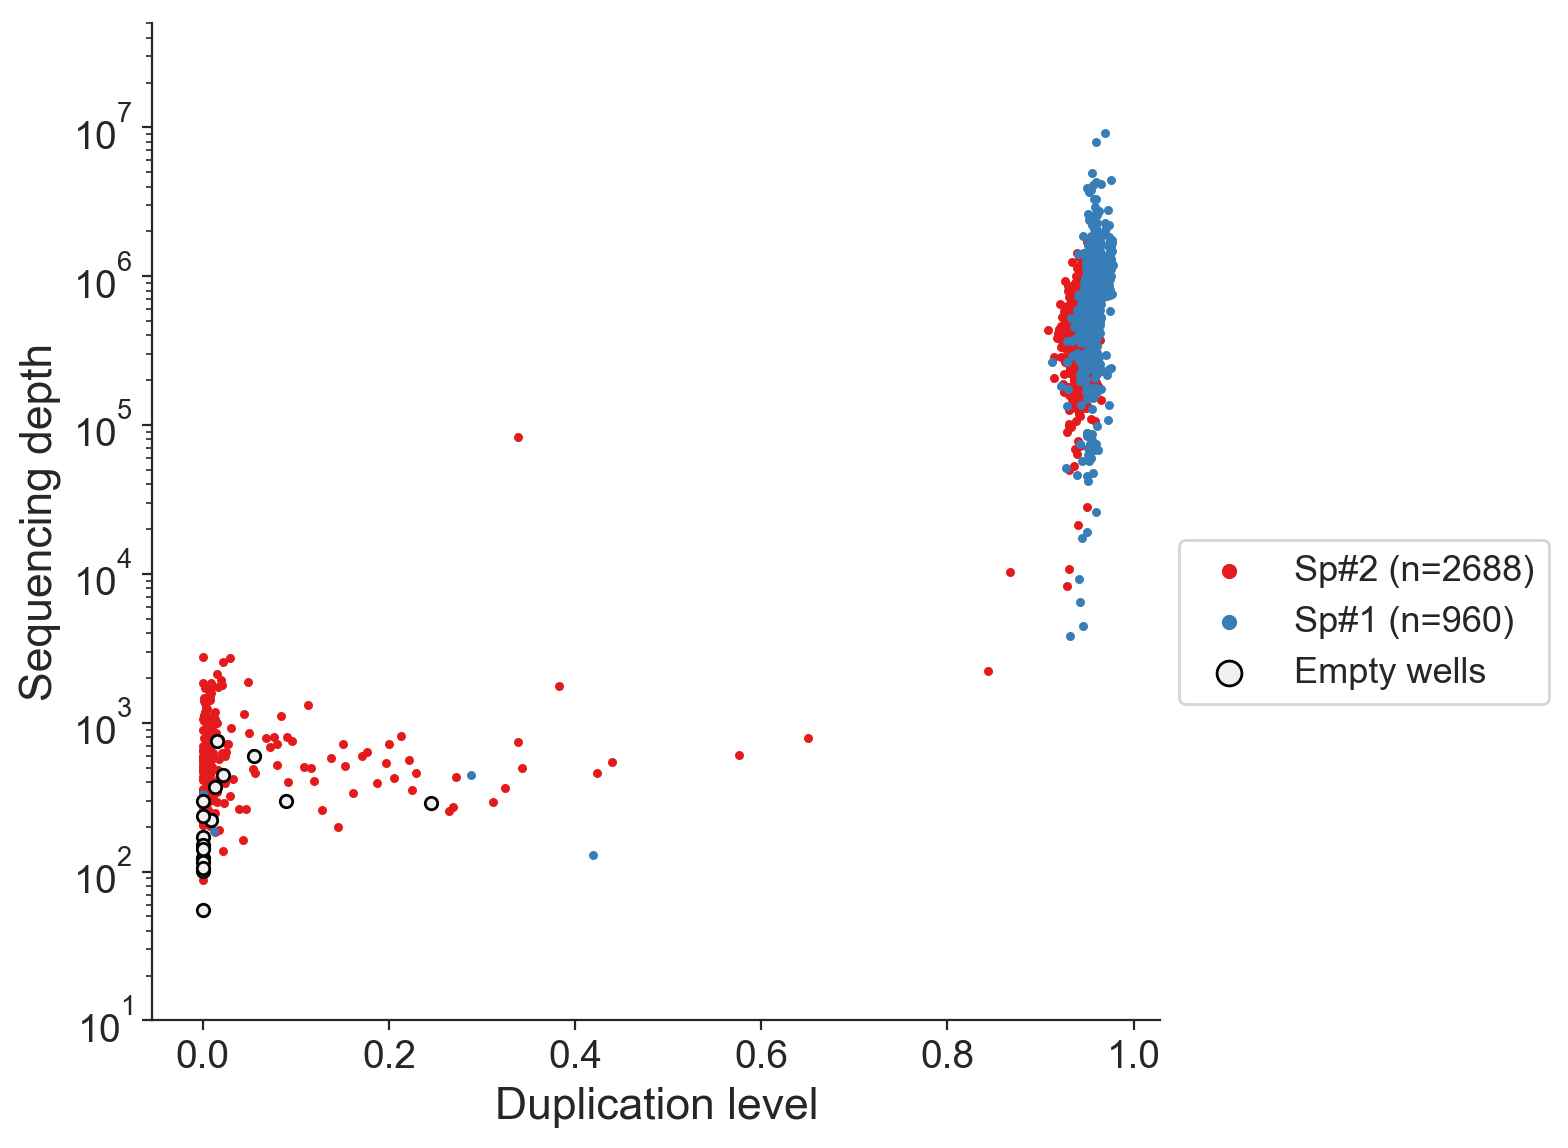

In [9]:
g = sns.FacetGrid(plate_qc.drop(labels=empty_cells), hue='batch', height=6)
g.map(plt.scatter, 'dup_level', 'sequencing_depth', s=5, rasterized=True)
g.ax.set_yscale('log')
g.ax.set_ylim(10, 5e7)

g.ax.scatter(plate_qc.loc[empty_cells, 'dup_level'],
             plate_qc.loc[empty_cells, 'sequencing_depth'],
             label='Empty wells', c='#f0f0f0',
             s=20, edgecolors='k')

g.ax.legend(bbox_to_anchor=[1., .5])

g.ax.set_xlabel('Duplication level')
g.ax.set_ylabel('Sequencing depth')

plt.savefig('figures/qc_sequencing_depth_vs_duplication_level.pdf',
            bbox_inches='tight', transparent=True)

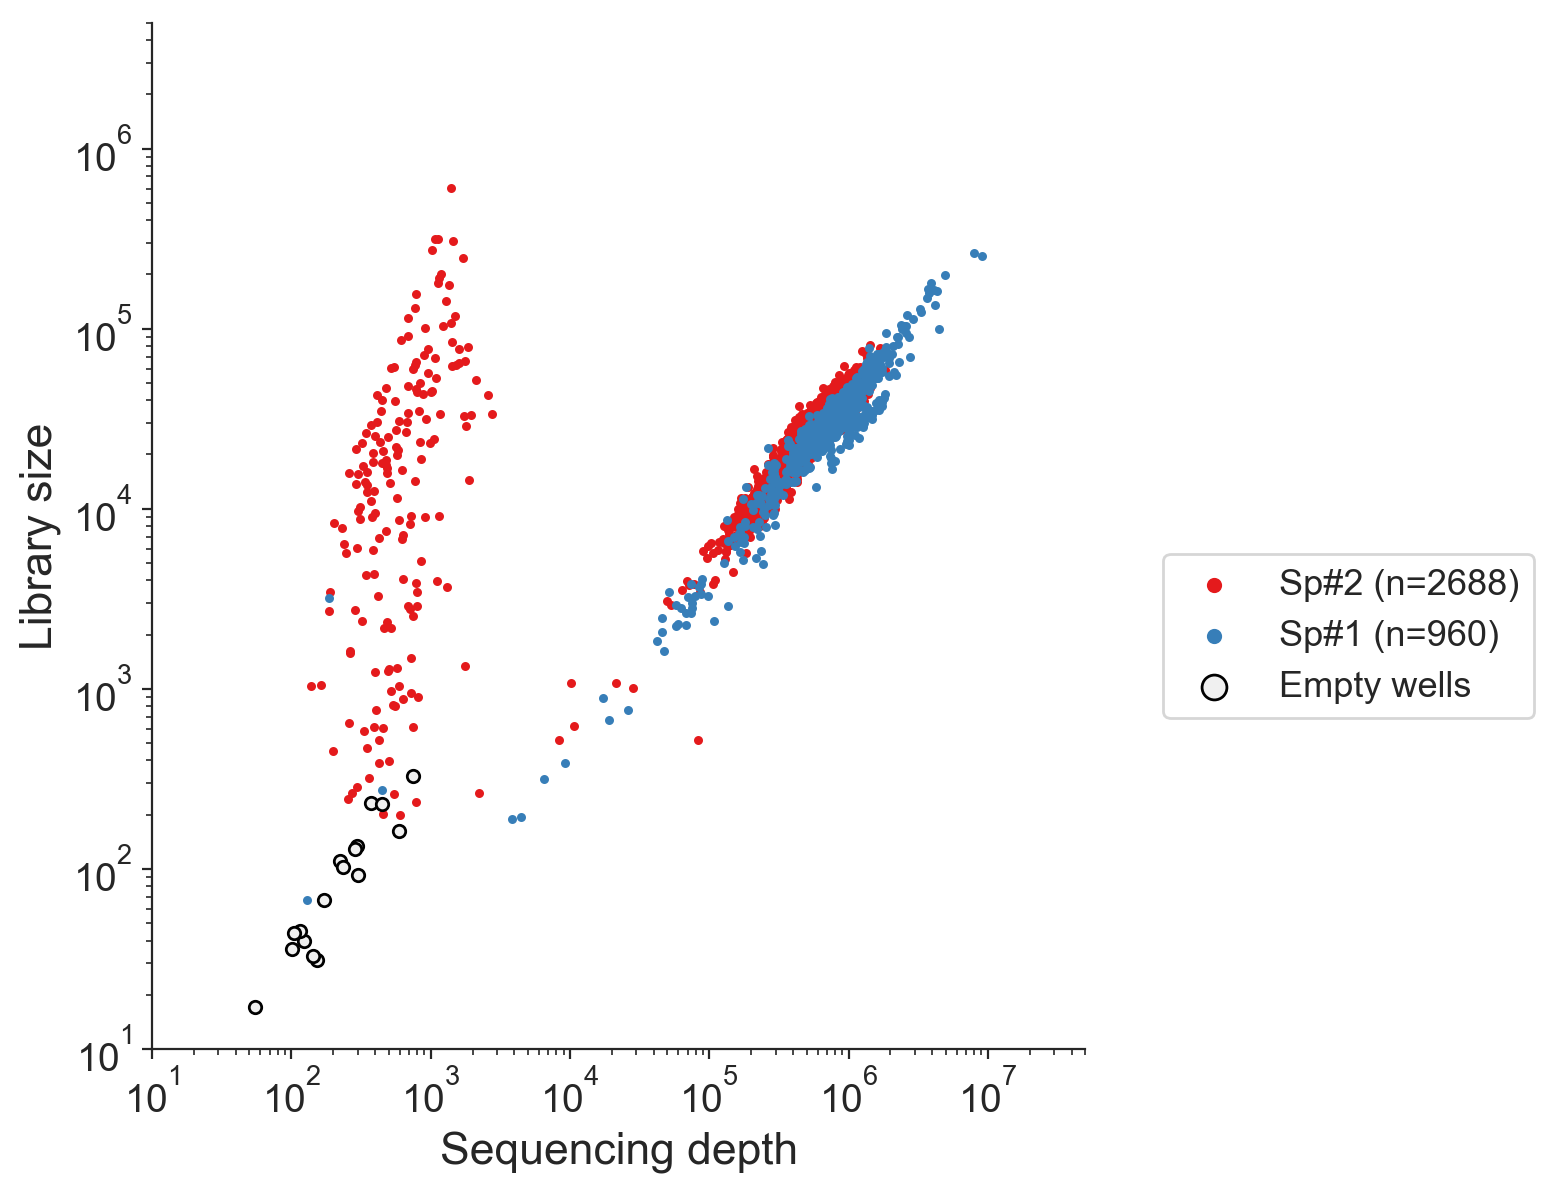

In [10]:
g = sns.FacetGrid(plate_qc.drop(labels=empty_cells), hue='batch', height=6)
g.map(plt.scatter, 'sequencing_depth', 'library_size', s=5, rasterized=True)
g.ax.set_xscale('log')
g.ax.set_yscale('log')
g.ax.set_xlim(10, 5e7)
g.ax.set_ylim(10, 5e6)

g.ax.scatter(plate_qc.loc[empty_cells, 'sequencing_depth'],
             plate_qc.loc[empty_cells, 'uniq_frags'],
             label='Empty wells', c='#f0f0f0',
             s=20, edgecolors='k')

g.ax.legend(bbox_to_anchor=[1.5, .5])

g.ax.set_xlabel('Sequencing depth')
g.ax.set_ylabel('Library size')

plt.savefig('figures/qc_sequencing_depth_vs_library_size.pdf',
            bbox_inches='tight', transparent=True)

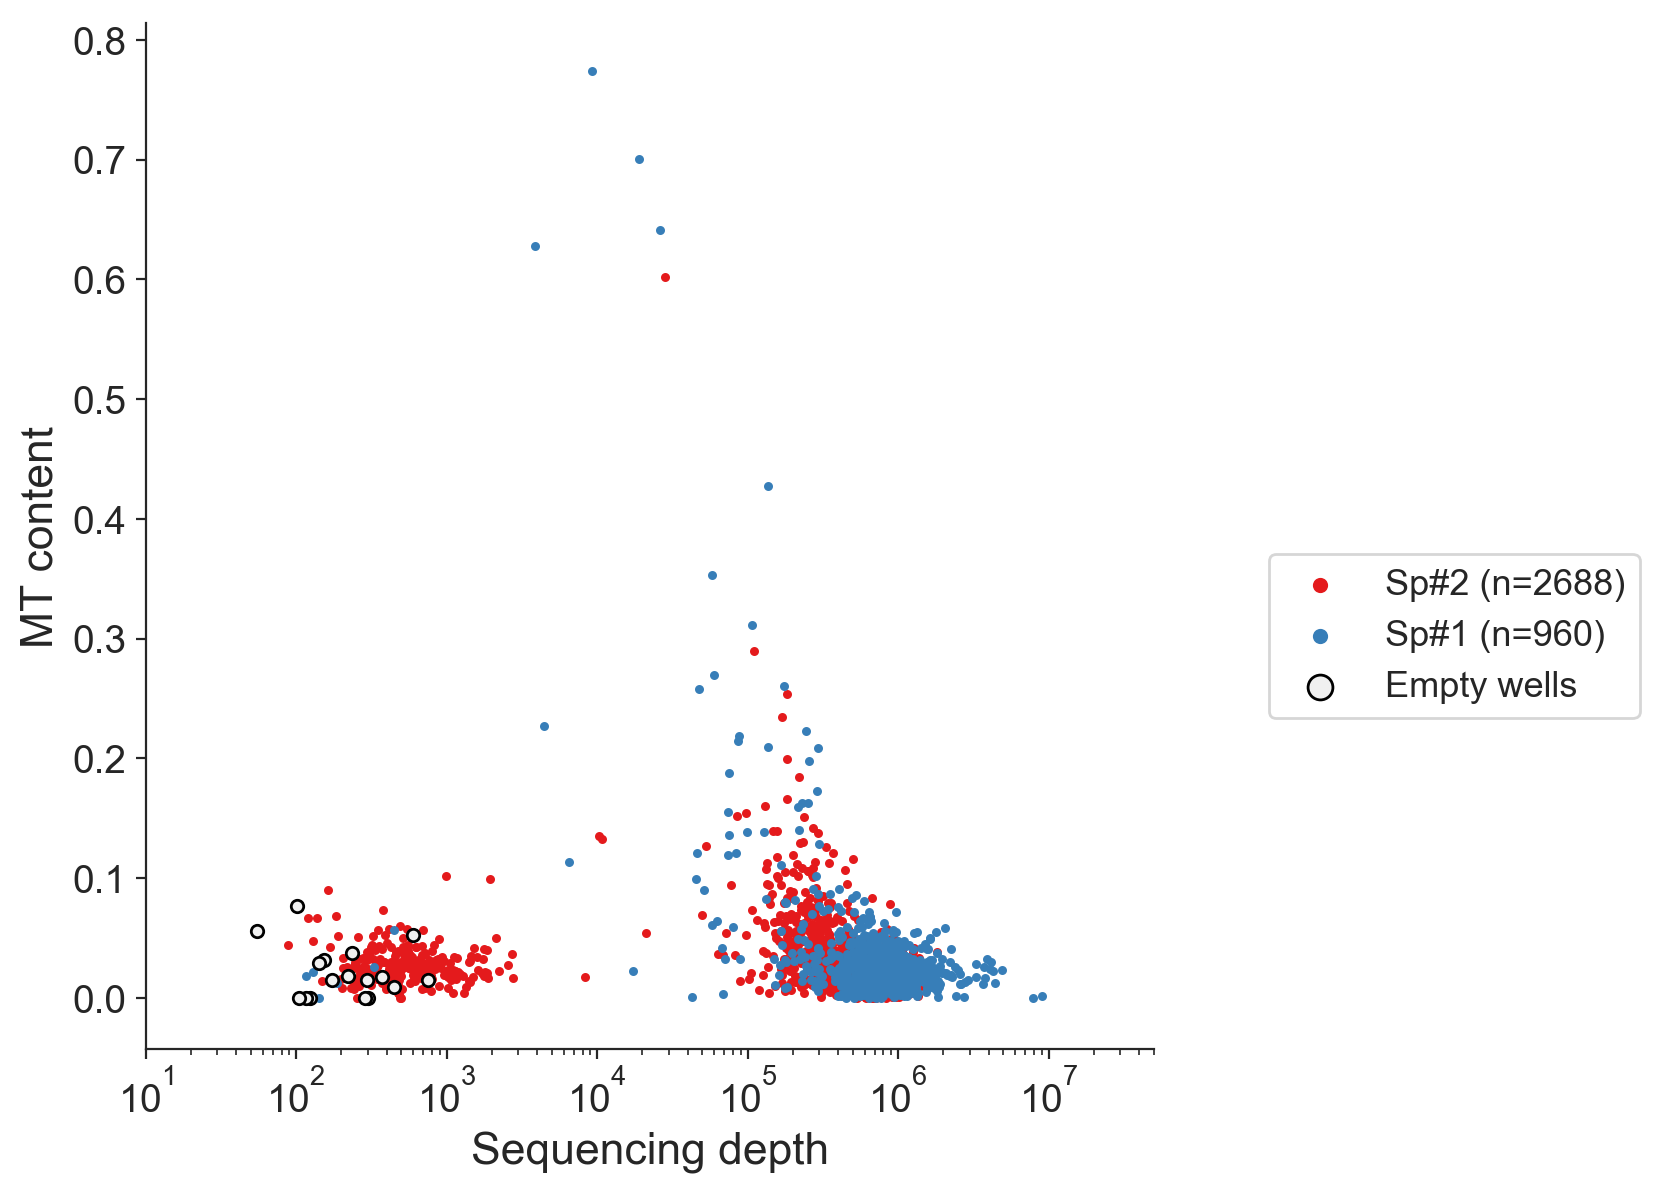

In [11]:
g = sns.FacetGrid(plate_qc.drop(labels=empty_cells), hue='batch', height=6)
g.map(plt.scatter, 'sequencing_depth', 'mt_content', s=5, rasterized=True)
g.ax.set_xscale('log')
g.ax.set_xlim(10, 5e7)

g.ax.scatter(plate_qc.loc[empty_cells, 'sequencing_depth'],
             plate_qc.loc[empty_cells, 'mt_content'],
             label='Empty wells', c='#f0f0f0',
             s=20, edgecolors='k')

g.ax.legend(bbox_to_anchor=[1.5, .5])

g.ax.set_xlabel('Sequencing depth')
g.ax.set_ylabel('MT content')

plt.savefig('figures/qc_sequencing_depth_vs_mt_content.pdf',
            bbox_inches='tight', transparent=True)

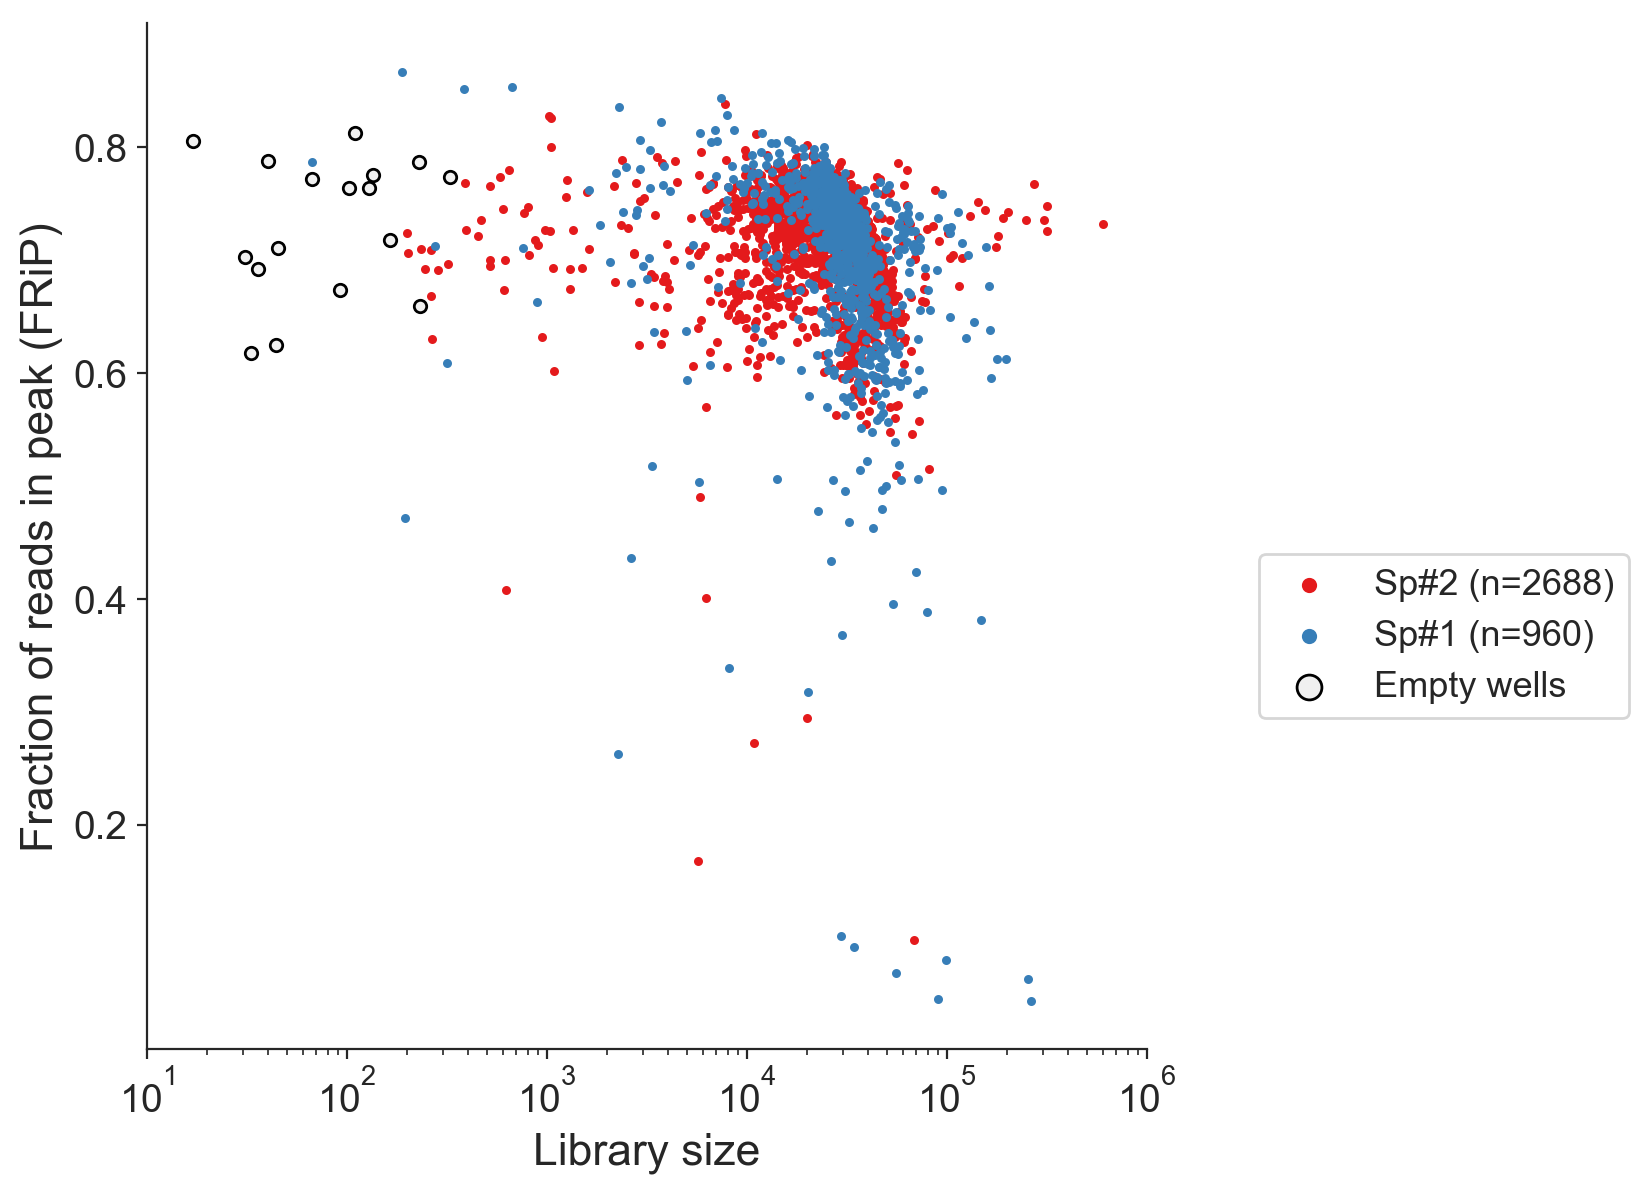

In [12]:
g = sns.FacetGrid(plate_qc.drop(labels=empty_cells), hue='batch', height=6)
g.map(plt.scatter, 'library_size', 'frip', s=5, rasterized=True)
g.ax.set_xscale('log')
g.ax.set_xlim(10, 1e6)

g.ax.scatter(plate_qc.loc[empty_cells, 'uniq_frags'],
             plate_qc.loc[empty_cells, 'frip'],
             label='Empty wells', c='#f0f0f0',
             s=20, edgecolors='k')

g.ax.legend(bbox_to_anchor=[1.5, .5])

g.ax.set_xlabel('Library size')
g.ax.set_ylabel('Fraction of reads in peak (FRiP)')

plt.savefig('figures/qc_library_size_vs_frip.pdf',
            bbox_inches='tight', transparent=True)

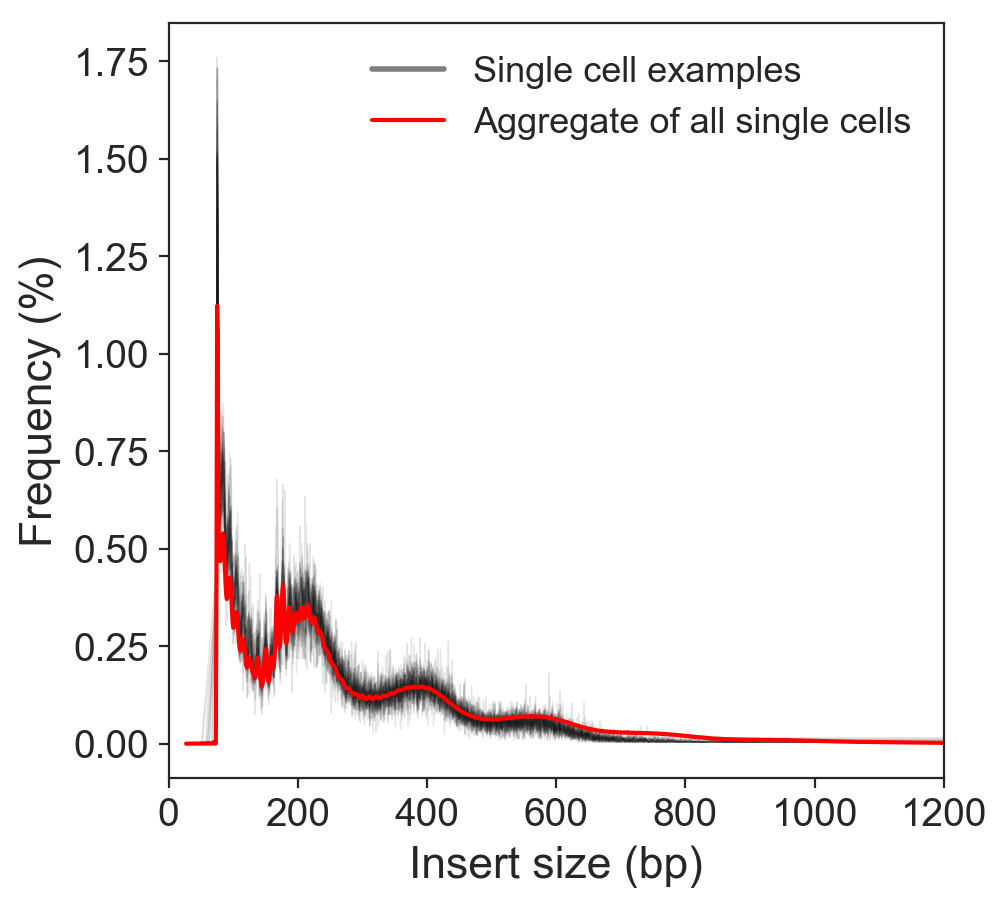

In [15]:
# look at the isize distritubtion
fig, ax = plt.subplots(figsize=(5,5))

# read the isize of aggregated data
merged = pd.read_table('mSp_scATAC-seq/aggregate/trim_rep1_isize_all_merged_pmd.hist',
                       sep=' ', header=None, names=['count', 'size'])

# read 24 single cells to plot
examples = ['mSp_scATAC-seq/rep9/isize_hist/mSp_rep9_{:0>3}_isize.hist'\
            .format(i) for i in range(1,24)]

scs = []
for i in examples:
    scs.append(pd.read_table(i, sep=' ', header=None, names=['count', 'size']))

ax.plot(scs[0]['size'],
        scs[0]['count']/scs[0]['count'].sum() * 100,
        'k-', label='Single cell examples', lw=.5, alpha=.1)

for sc in scs[1:]:
    ax.plot(sc['size'],
            sc['count']/sc['count'].sum() * 100,
            'k-', lw=.5, alpha=.1, label='')

ax.plot(merged['size'],
        merged['count']/merged['count'].sum() * 100,
        'r-', lw=1.5, label='Aggregate of all single cells')

lg = ax.legend(frameon=False)
lg_lines = lg.get_lines()
lg_lines[0].set_linewidth(2)
lg_lines[0].set_alpha(.5)

ax.set_xlim(0,1200)
ax.set_xlabel('Insert size (bp)')
ax.set_ylabel('Frequency (%)', )

plt.savefig('figures/fragment_size_distribution.pdf',
            bbox_inches='tight', transparent=True)

Text(0, 0.5, 'Tag density')

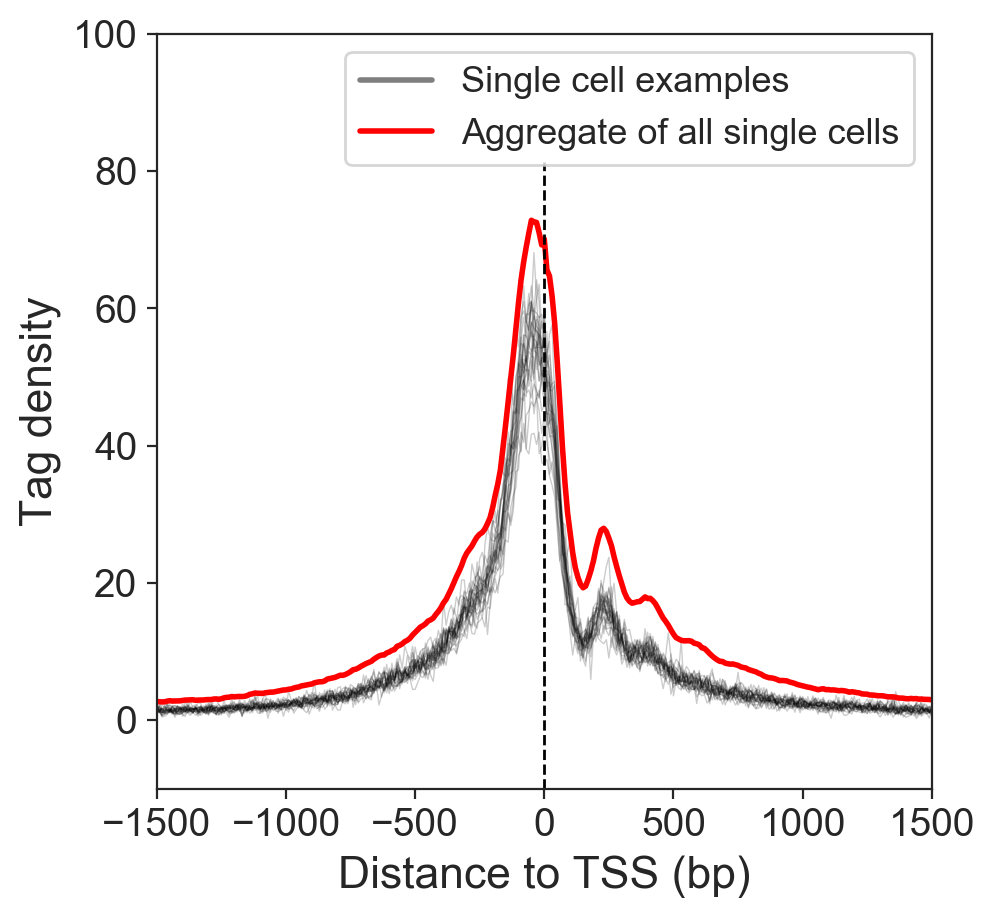

In [16]:
# look at the read distribution around TSS

# read output from homer
den = pd.read_table('mSp_scATAC-seq/tagdensity_around_mm10_tss_by_homer_annotatepeaks.txt',
                    skiprows=1, header=None, usecols = range(1, 76, 3),
                    names = ['aggregate'] + ['sc_{}'.format(i) for i in range(1,25)])

fig, ax = plt.subplots(figsize=(5,5))

x = np.linspace(-1500, 1500, num=301)

ax.plot(x, den['sc_1'], 'k-', label='Single cell examples', lw=.5, alpha=.2)
for sc in den.columns[2:]:
    ax.plot(x, den[sc], 'k-', lw=.5, alpha=.2, label='')

ax.plot(x, den['aggregate'], 'r-', lw=2, label='Aggregate of all single cells')

lg = ax.legend()
lg_lines = lg.get_lines()
lg_lines[0].set_linewidth(2)
lg_lines[0].set_alpha(.5)

ax.axvline(x=0, ymin=0, ymax=.83, ls='dashed', c='k', lw=1)
ax.set_xlim(-1500,1500)
ax.set_ylim(-10, 100)

ax.set_xlabel('Distance to TSS (bp)')
ax.set_ylabel('Tag density')

# plt.savefig('figures/tss_plot.pdf', bbox_inches='tight', transparent=True)

In [17]:
# # output bad cells

bad_cells = plate_qc[(plate_qc.sequencing_depth < 1e4) | (plate_qc.mapping_rate < 90)]
# bad_cells.to_csv('mSp_scATAC-seq/qc_bad_cells.csv')

In [4]:
# plate_qc.to_csv('mSp_scATAC-seq/qc_all.csv')

In [19]:
bad_cells.shape[0]

262

# Downsampling analysis to look at # of unique fragments

In [37]:
!ls downsampling/*/qc_metrics/library_size.txt

downsampling/0.1/qc_metrics/library_size.txt
downsampling/0.2/qc_metrics/library_size.txt
downsampling/0.3/qc_metrics/library_size.txt
downsampling/0.4/qc_metrics/library_size.txt
downsampling/0.5/qc_metrics/library_size.txt
downsampling/0.6/qc_metrics/library_size.txt
downsampling/0.7/qc_metrics/library_size.txt
downsampling/0.8/qc_metrics/library_size.txt
downsampling/0.9/qc_metrics/library_size.txt


In [38]:
f = list(iglob('downsampling/*/qc_metrics/library_size.txt'))
f.sort()

dfs = []

for i in f:
    frac = i.split('/')[1]
    dfs.append(pd.read_table(i, header=None, skiprows=1, names=['cell', frac],
                             index_col='cell'))
ufrags = pd.concat(dfs, axis=1)
ufrags['1.0'] = plate_qc.loc[:, 'library_size']
ufrags.head(2)

0.1      0.2      0.3      0.4      0.5      0.6      0.7  \
cell                                                                          
mSp_rep3_001  30673.0  32433.0  33277.0  33783.0  34139.0  34415.0  34652.0   
mSp_rep3_002   6673.0   7066.0   7251.0   7379.0   7477.0   7551.0   7607.0   

                  0.8      0.9      1.0  
cell                                     
mSp_rep3_001  34877.0  35061.0  35235.0  
mSp_rep3_002   7656.0   7695.0   7745.0

In [41]:
ufrags.median()

0.1    26742.0
0.2    28285.0
0.3    29255.0
0.4    29753.0
0.5    30103.0
0.6    30381.0
0.7    30606.0
0.8    30811.0
0.9    30999.0
1.0    31172.0
dtype: float64

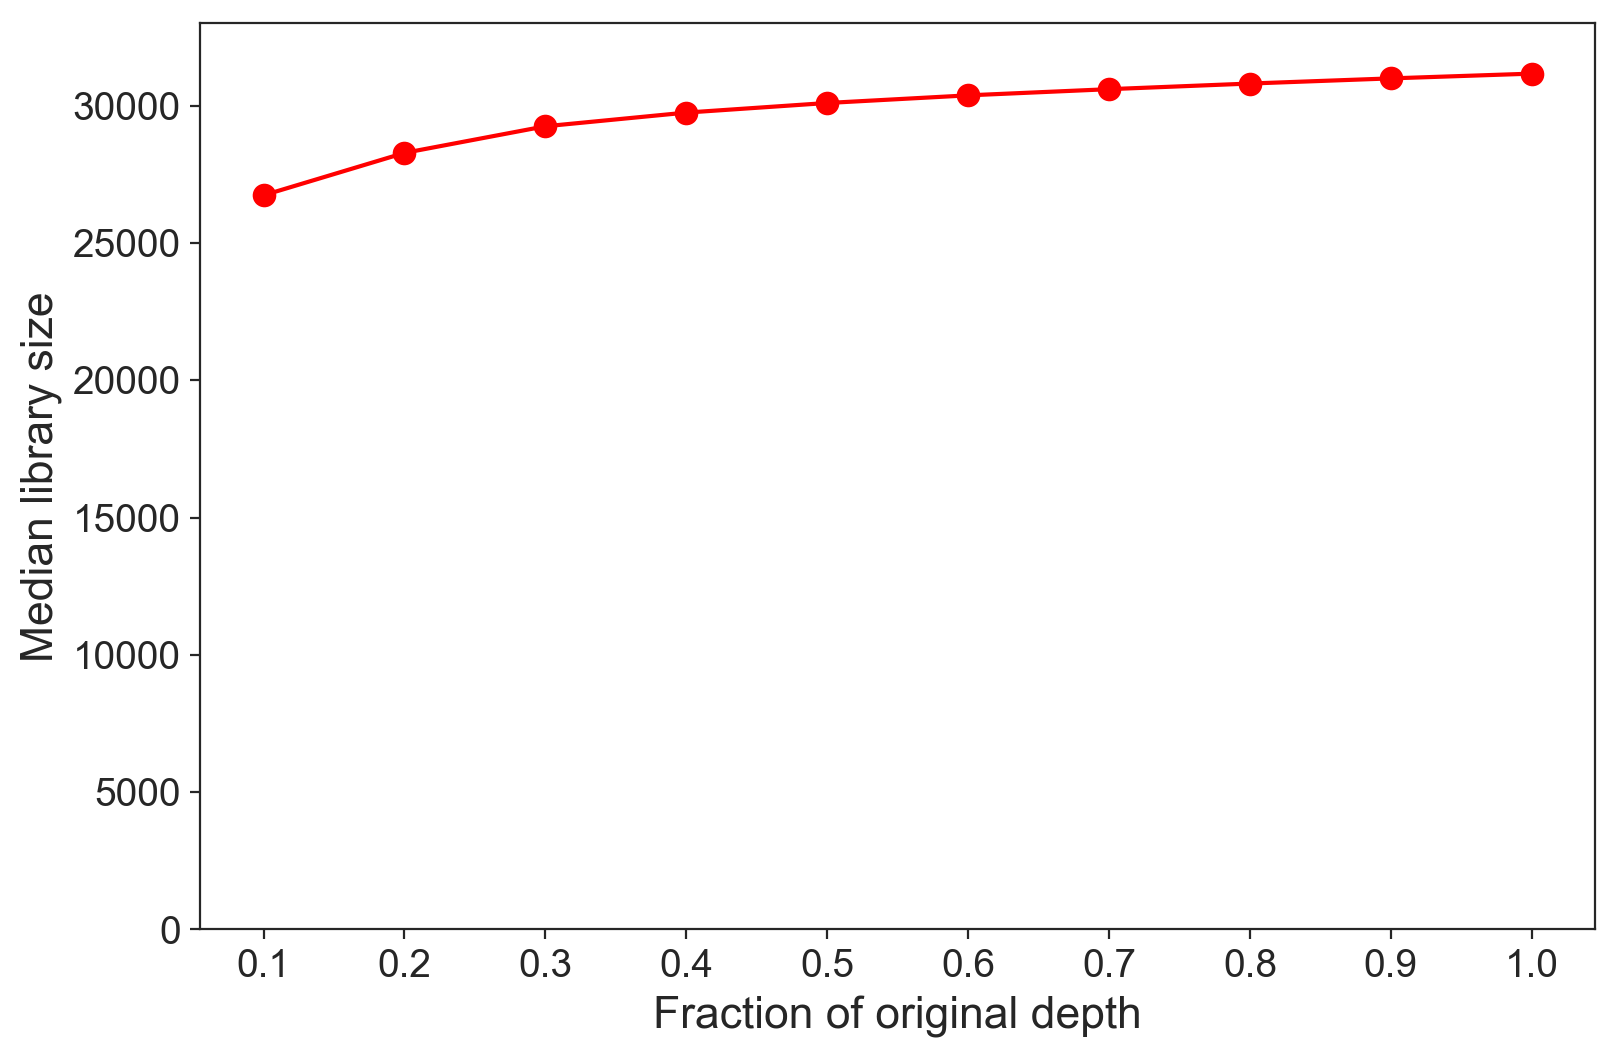

In [40]:
plt.figure(figsize=(9, 6))
plt.plot(ufrags.columns.astype(float), ufrags.median(), 'r.-', ms=15)
plt.xticks(ufrags.columns.astype(float), ufrags.columns.values)
plt.ylim(0, 33000)
plt.xlabel('Fraction of original depth')
plt.ylabel('Median library size')

plt.savefig('figures/subsampling_unique_fragments_median.pdf',
            bbox_inches='tight', transparent=True)

/Users/xc1/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


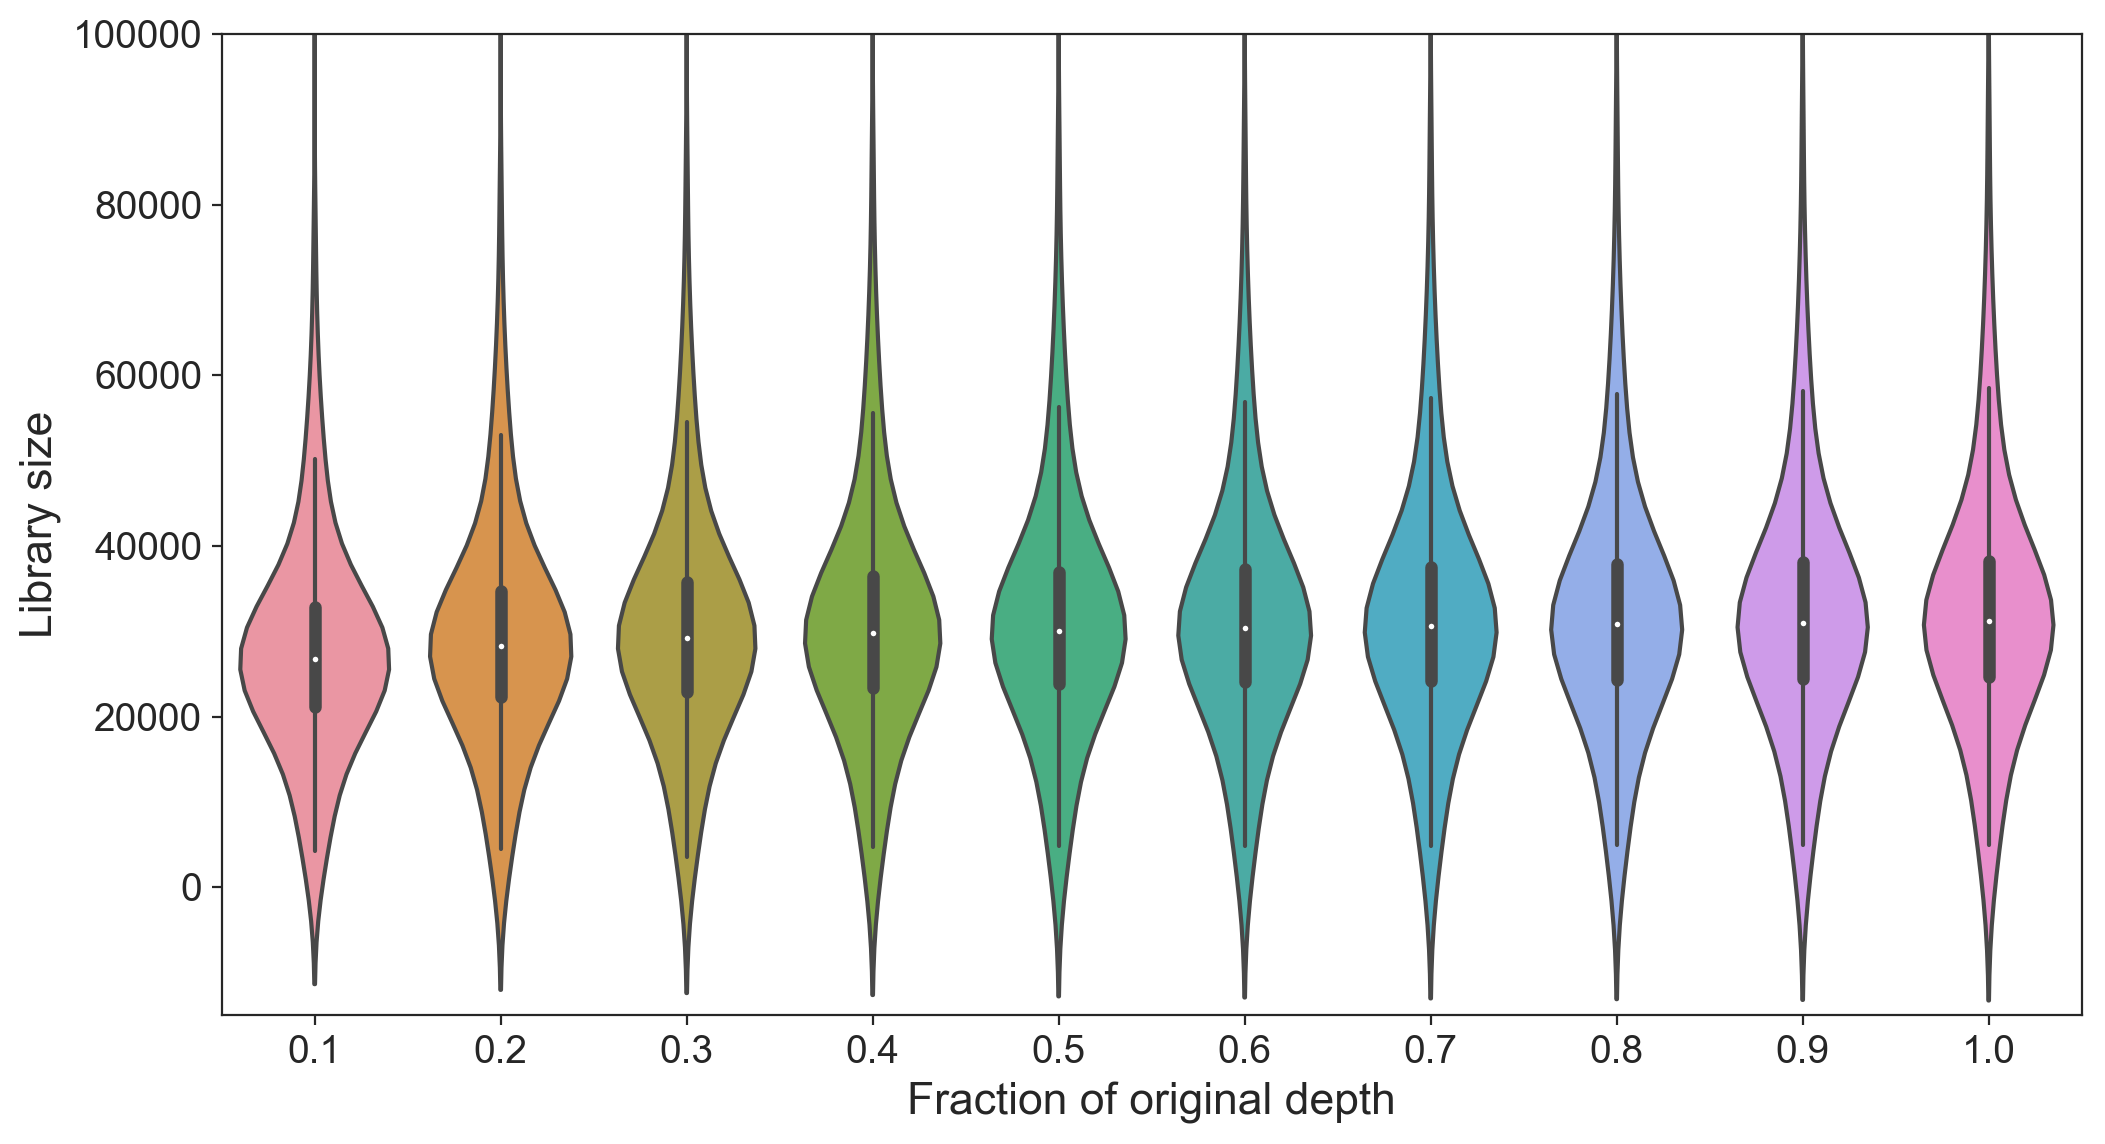

In [42]:
violin_data = ufrags.melt(value_vars=ufrags.columns)

fig, ax = plt.subplots(figsize=(12, 6.5))

sns.violinplot(x='variable', y='value', data=violin_data, ax=ax)
ax.set_xlabel('Fraction of original depth')
ax.set_ylabel('Library size')
ax.set_ylim(-15000, 100000)

plt.savefig('figures/subsampling_unique_fragments_violin.pdf',
            bbox_inches='tight', transparent=True)

# Perform some basic exploratory analysis

In [43]:
from scipy.io import mmread

count = mmread('cmp_to_immgen/mSp_scATAC_count_matrix_over_all.mtx')
idxs = [i.strip() for i in open('cmp_to_immgen/mSp_scATAC_count_matrix_over_all.rownames')]
cols = [i.strip() for i in open('cmp_to_immgen/mSp_scATAC_count_matrix_over_all.colnames')]

sc_count = pd.DataFrame(data=count.toarray(),
                        index=idxs,
                        columns=cols)

sc_count.drop(labels=bad_cells.index, axis=1, inplace=True)

# binarise the data
bin_sc_count = sc_count.where(sc_count < 1, 1)
sc_count = sc_count.loc[bin_sc_count.index, bin_sc_count.columns]
bin_sc_count.shape

(127856, 3386)

In [44]:
bin_sc_count.head(2)

mSp_rep7_276  mSp_rep7_267  mSp_rep7_325  mSp_rep7_270  \
spleen_uPk_1             0             0             0             0   
spleen_uPk_2             0             0             0             0   

              mSp_rep7_092  mSp_rep7_291  mSp_rep7_196  mSp_rep7_347  \
spleen_uPk_1             0             0             0             0   
spleen_uPk_2             0             0             0             0   

              mSp_rep7_141  mSp_rep7_079      ...       mSp_rep6_216  \
spleen_uPk_1             0             0      ...                  0   
spleen_uPk_2             0             0      ...                  0   

              mSp_rep6_110  mSp_rep6_353  mSp_rep6_174  mSp_rep6_255  \
spleen_uPk_1             0             0             0             0   
spleen_uPk_2             0             0             0             0   

              mSp_rep6_250  mSp_rep6_280  mSp_rep6_046  mSp_rep6_302  \
spleen_uPk_1             0             0             0             0   
spleen_uPk_2             0             0             0             0   

              mSp_rep6_019  
spleen_uPk_1             0  
spleen_uPk_2             0  

[2 rows x 3386 columns]

In [45]:
# perform Latent Semantic Indexing Analysis

# get TF-IDF matrix
tfidf = TfidfTransformer(norm='l2', sublinear_tf=True)
normed_count = tfidf.fit_transform(bin_sc_count.T)

# perform SVD on the sparse matrix
lsi = TruncatedSVD(n_components=20, random_state=42)
lsi_r = lsi.fit_transform(normed_count)

lsi.explained_variance_ratio_

array([0.00615814, 0.03146934, 0.00830842, 0.00660499, 0.00400276,
       0.00236671, 0.00210679, 0.00187625, 0.00165964, 0.0012722 ,
       0.00110199, 0.00104292, 0.0008829 , 0.00078783, 0.00077141,
       0.00070846, 0.00066163, 0.00064193, 0.0005851 , 0.00056336])

In [46]:
plate_qc = plate_qc.loc[bin_sc_count.columns]
for i in range(3):
    plate_qc['LSI Dimension {}'.format(i+1)] = lsi_r[:, i]
plate_qc = plate_qc.loc[sorted(plate_qc.index)]

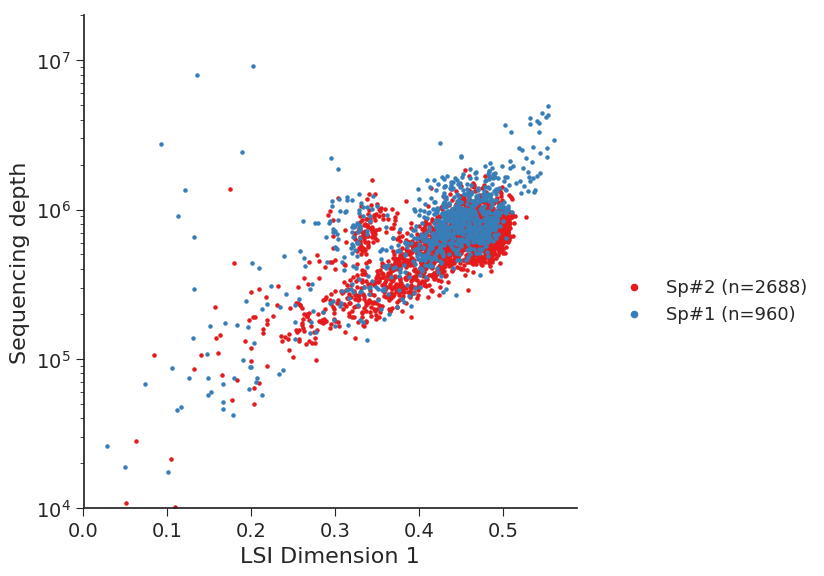

In [38]:
# have a look the first dimension and the sequencing depth

g = sns.FacetGrid(plate_qc, hue='batch', size=6)
g.map(plt.scatter, 'LSI Dimension 1', 'sequencing_depth', s=5, )
g.ax.legend(bbox_to_anchor=[1.5, .5])
g.ax.set_yscale('log')
g.ax.set_ylim(1e4, 2e7)
g.ax.set_ylabel('Sequencing depth')

plt.savefig('figures/LSI_1st_dimension_vs_sequencing_depth.pdf',
            bbox_inches='tight', transparent=True)

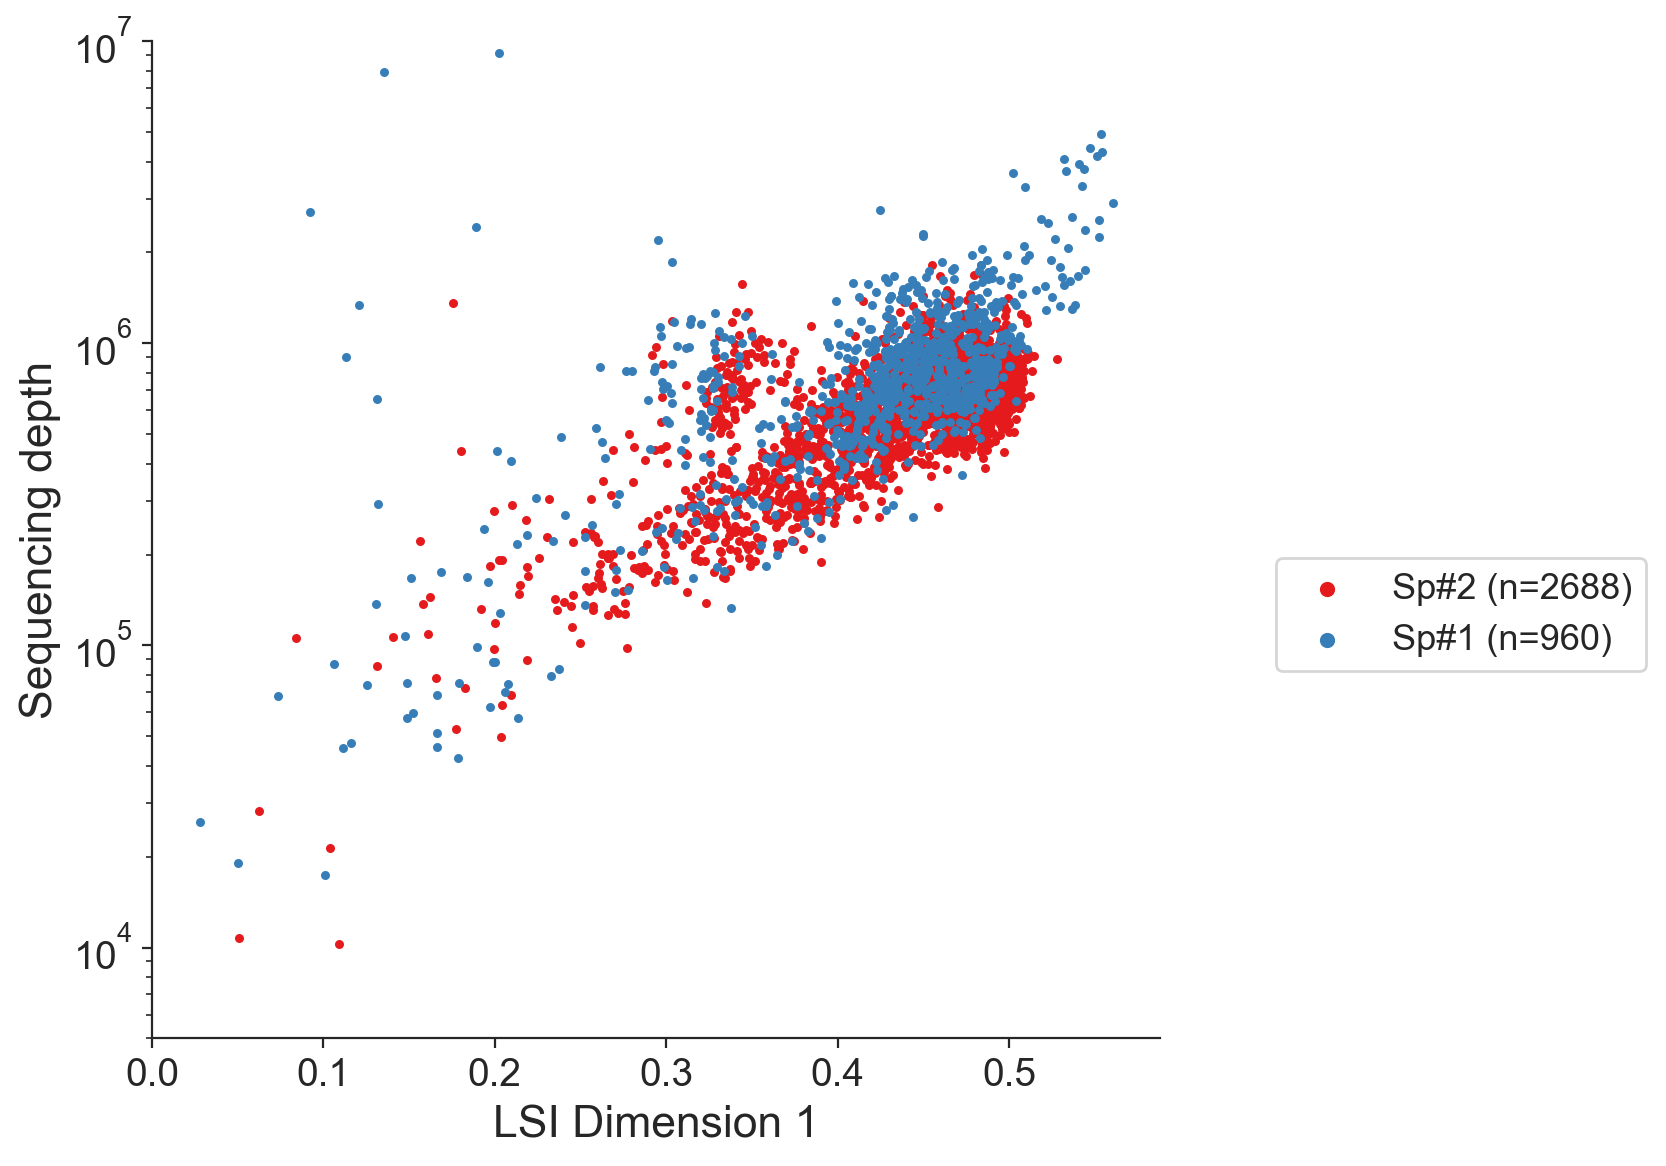

In [50]:
# have a look the first dimension and the uniq frags

g = sns.FacetGrid(plate_qc, hue='batch', height=6)
g.map(plt.scatter, 'LSI Dimension 1', 'sequencing_depth', s=5, rasterized=True)
g.ax.legend(bbox_to_anchor=[1.5, .5])
g.ax.set_yscale('log')
g.ax.set_ylim(5e3, 1e7)
g.ax.set_ylabel('Sequencing depth')

plt.savefig('figures/LSI_1st_dimension_vs_sequencing_depth.pdf',
            bbox_inches='tight', transparent=True)

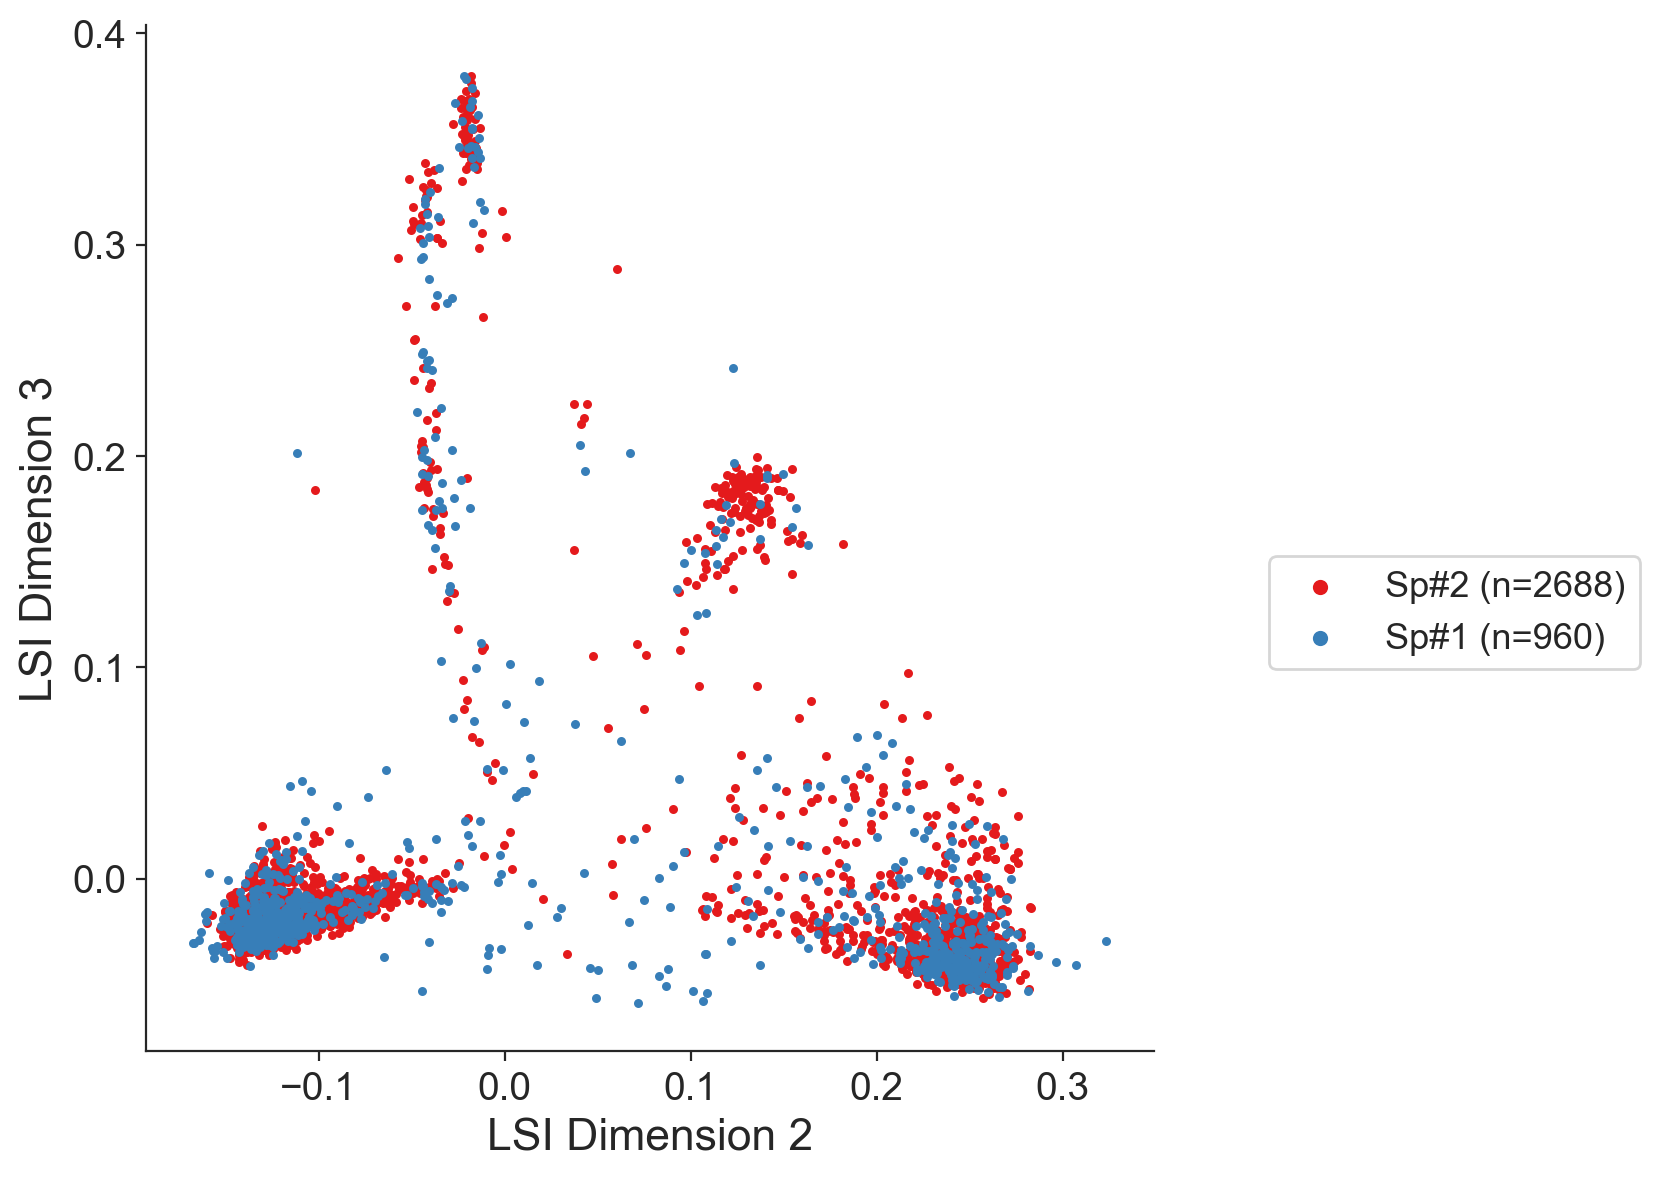

In [52]:
g = sns.FacetGrid(plate_qc, hue='batch', height=6)
g.map(plt.scatter, 'LSI Dimension 2', 'LSI Dimension 3', s=5)
g.ax.legend(bbox_to_anchor=[1.5, .5])

In [53]:
# check peaks linked to some marker genes (by annotatePeaks.pl from the HOMER suite)

homer = pd.read_table('cmp_to_immgen/homer_annotation_spleen_union_peaks_no_black_list.txt', index_col=0)
marker_genes = ['Bcl11a', 'Bcl11b', 'Cd3e', 'Cd4',
                'Cd8a', 'Cd19', 'Ms4a1', 'Ebf1',
                'Tcf7', 'Gzma', 'Lrg1']

marker_p2g = homer[homer['Gene Name'].isin(marker_genes)]['Gene Name']
marker_count = pd.concat([sc_count, marker_p2g], axis=1, join='inner')
marker_count.head(2)

mSp_rep7_276  mSp_rep7_267  mSp_rep7_325  mSp_rep7_270  \
spleen_uPk_17545             0             0             0             0   
spleen_uPk_17546             0             0             0             0   

                  mSp_rep7_092  mSp_rep7_291  mSp_rep7_196  mSp_rep7_347  \
spleen_uPk_17545             0             2             0             6   
spleen_uPk_17546             0             0             0             0   

                  mSp_rep7_141  mSp_rep7_079    ...      mSp_rep6_110  \
spleen_uPk_17545             0             0    ...                 4   
spleen_uPk_17546             0             0    ...                 0   

                  mSp_rep6_353  mSp_rep6_174  mSp_rep6_255  mSp_rep6_250  \
spleen_uPk_17545             0             0             0             0   
spleen_uPk_17546             1             0             0             0   

                  mSp_rep6_280  mSp_rep6_046  mSp_rep6_302  mSp_rep6_019  \
spleen_uPk_17545             4             0             7             0   
spleen_uPk_17546             0             0             2             0   

                  Gene Name  
spleen_uPk_17545     Bcl11a  
spleen_uPk_17546     Bcl11a  

[2 rows x 3387 columns]

In [54]:
marker_sum = marker_count.groupby('Gene Name').sum()
marker_sum

mSp_rep7_276  mSp_rep7_267  mSp_rep7_325  mSp_rep7_270  \
Gene Name                                                           
Bcl11a                5            21             4             0   
Bcl11b               17             0             0            11   
Cd19                  0             2             2             0   
Cd3e                 10             0             0             4   
Cd4                   2             2             0             0   
Cd8a                 13             0             0            12   
Ebf1                  0            11             2             0   
Gzma                  0             0             0             0   
Lrg1                  0             0             0             0   
Ms4a1                 0             5             0             0   
Tcf7                 36             1             0            27   

           mSp_rep7_092  mSp_rep7_291  mSp_rep7_196  mSp_rep7_347  \
Gene Name                                                           
Bcl11a                6            35             0            32   
Bcl11b                0             0            18             0   
Cd19                  4             5             0             5   
Cd3e                  0             2             2             2   
Cd4                   0             0             9             0   
Cd8a                  0             0             1             0   
Ebf1                  0            40             0            18   
Gzma                  0             0             0             0   
Lrg1                  1             0             0             0   
Ms4a1                 0            13             0             5   
Tcf7                  0             0            25             6   

           mSp_rep7_141  mSp_rep7_079      ...       mSp_rep6_216  \
Gene Name                                  ...                      
Bcl11a                4             0      ...                  3   
Bcl11b                0            30      ...                  0   
Cd19                  0             0      ...                  0   
Cd3e                  0             6      ...                  0   
Cd4                   0             2      ...                  0   
Cd8a                  0             0      ...                  0   
Ebf1                  4             0      ...                  2   
Gzma                  0             0      ...                  0   
Lrg1                  0             0      ...                  0   
Ms4a1                 0             0      ...                  0   
Tcf7                  0            23      ...                  0   

           mSp_rep6_110  mSp_rep6_353  mSp_rep6_174  mSp_rep6_255  \
Gene Name                                                           
Bcl11a               42            16             9             4   
Bcl11b                0             0             0            18   
Cd19                  8             2             0             0   
Cd3e                  0             0             0             5   
Cd4                   0             1             0             0   
Cd8a                  0             0             0             4   
Ebf1                 16             3             0             0   
Gzma                  0             0             0             0   
Lrg1                  0             0             0             0   
Ms4a1                 2             0             0             0   
Tcf7                  0             2             0            11   

           mSp_rep6_250  mSp_rep6_280  mSp_rep6_046  mSp_rep6_302  \
Gene Name                                                           
Bcl11a                0            30             0            42   
Bcl11b               15             0             8             0   
Cd19                  0            12             0             6   
Cd3e                  0             0             0             0   
Cd4  

In [55]:
for g in marker_genes:
    plate_qc[g] = marker_sum.loc[g]

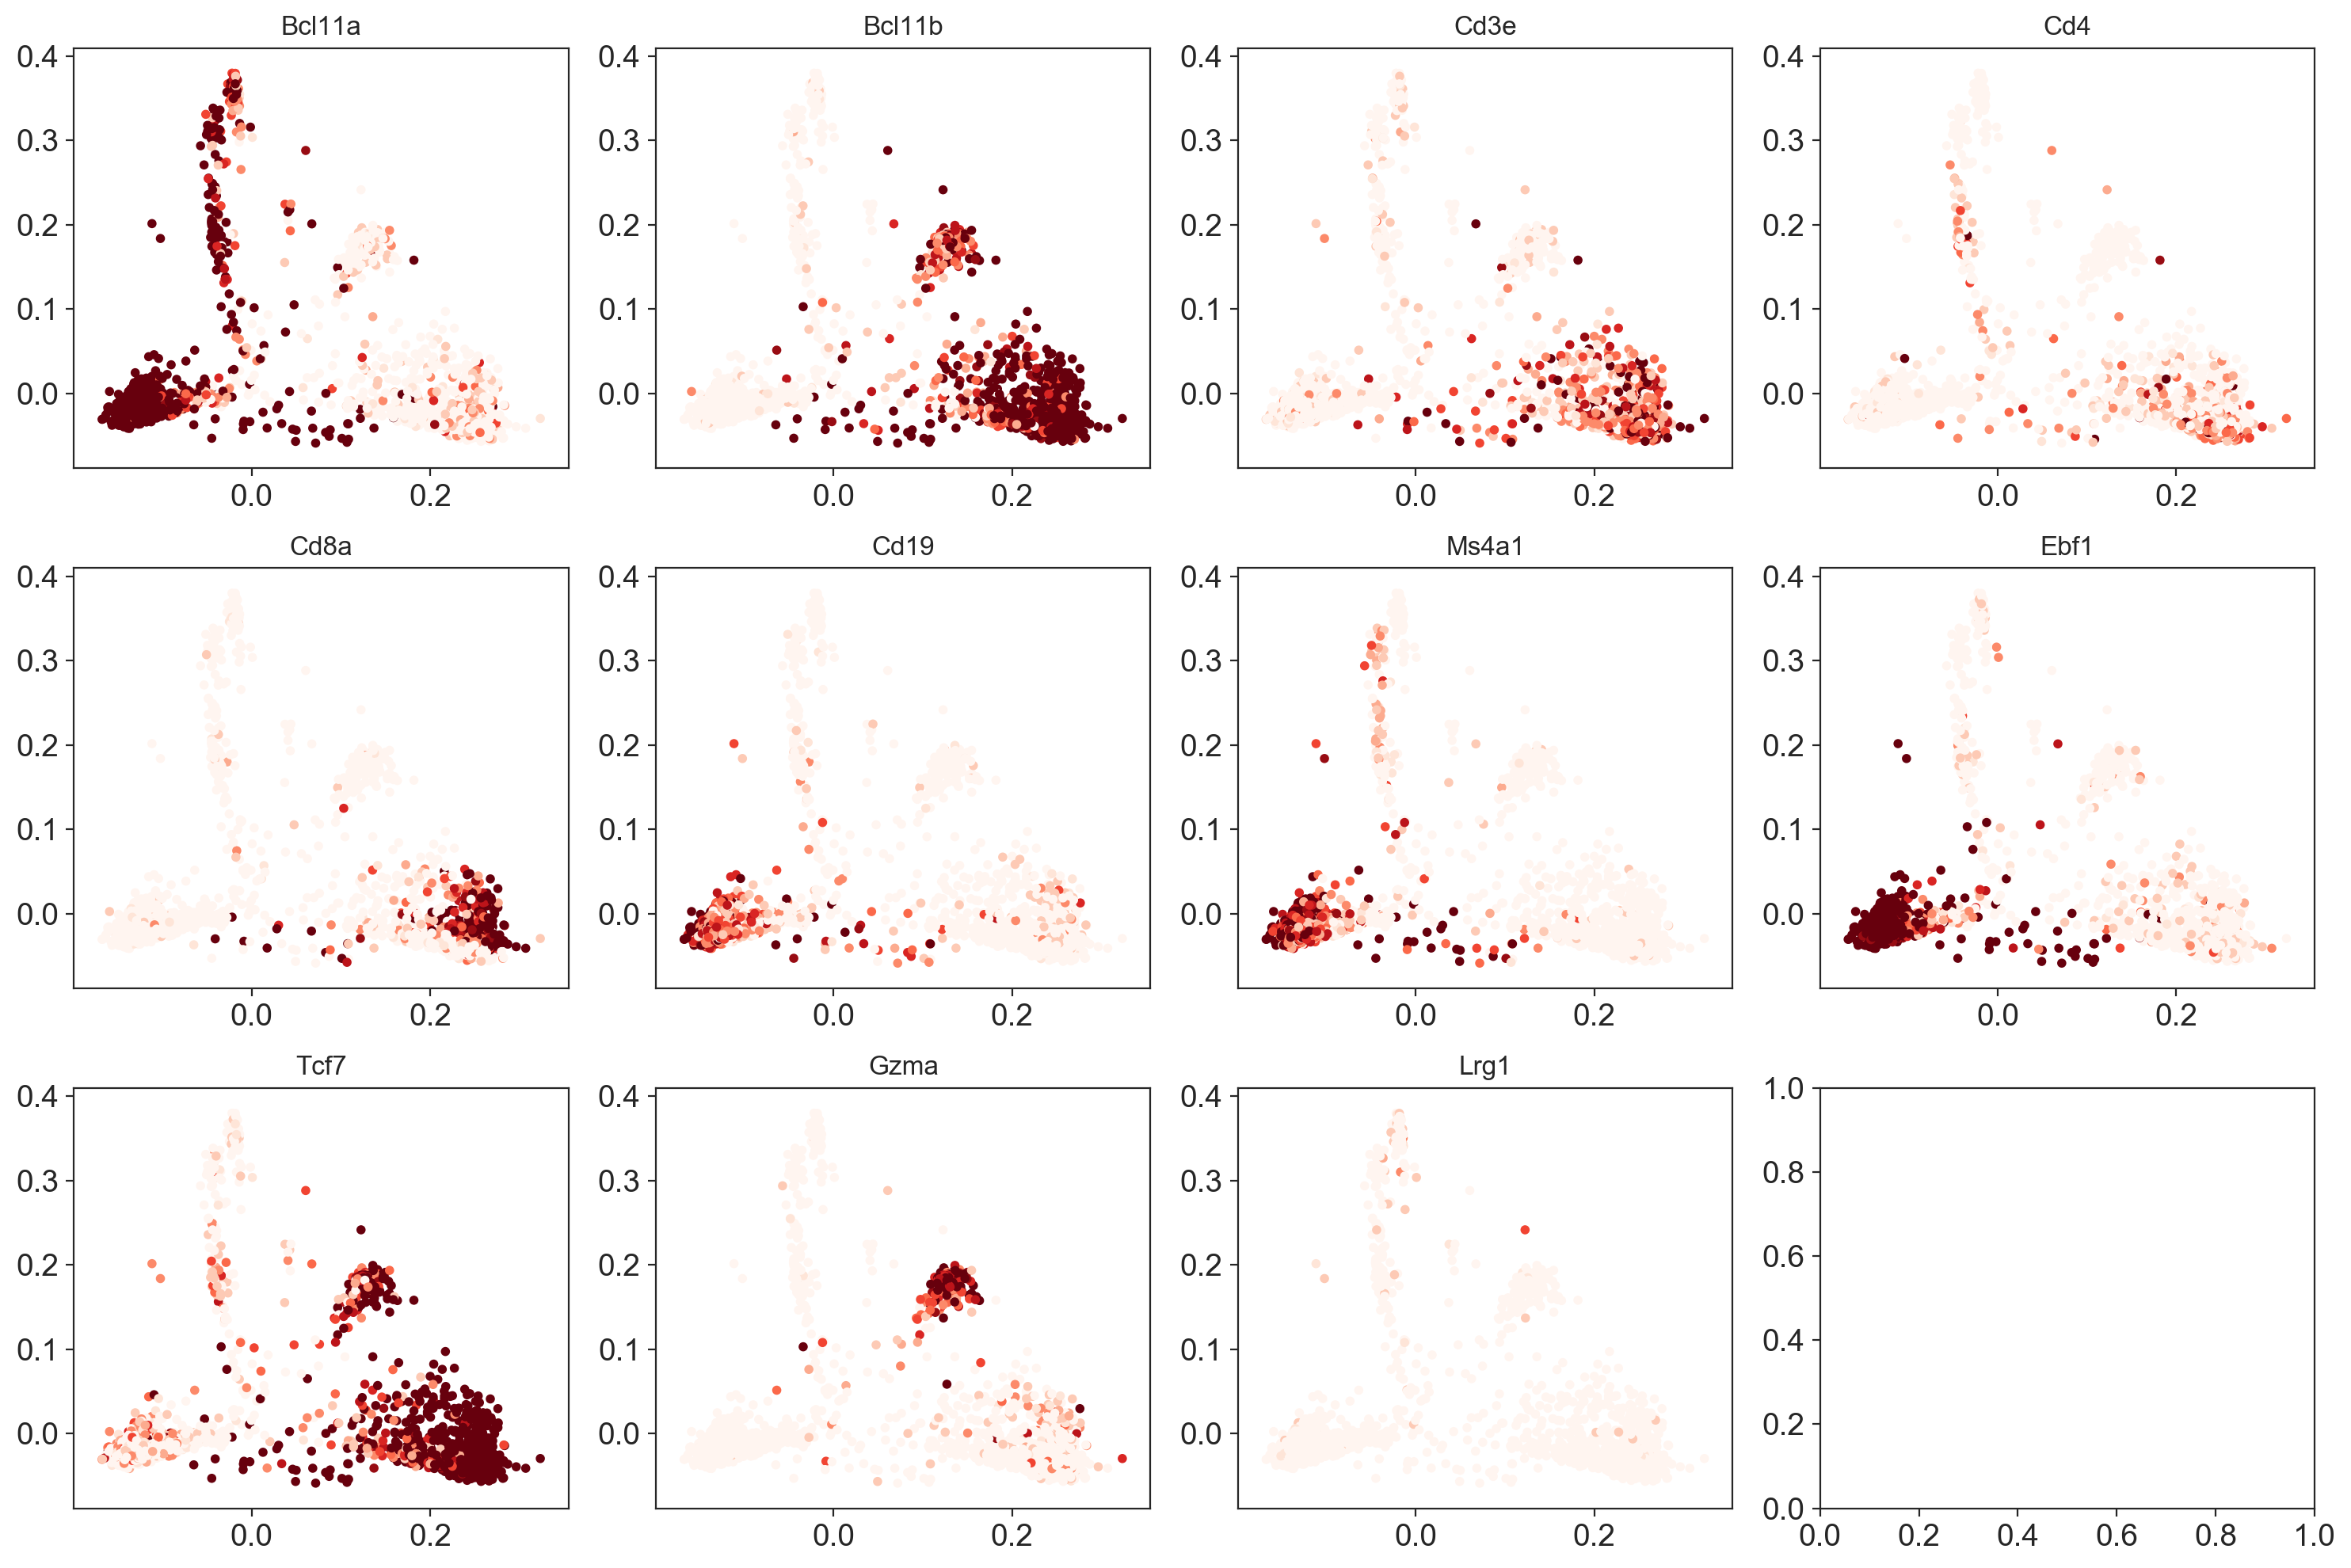

In [56]:
fig, ax = plt.subplots(figsize=(15, 10), ncols=4, nrows=3)
ax = ax.flatten()

for i, j in enumerate(marker_genes):
    ax[i].scatter(plate_qc['LSI Dimension 2'], plate_qc['LSI Dimension 3'],
                  cmap='Reds', c=plate_qc[j], vmin=0, vmax=10, s=10)
    ax[i].set_title(j, fontsize=12)

plt.tight_layout()
plt.show()

(0.5, 2.5)

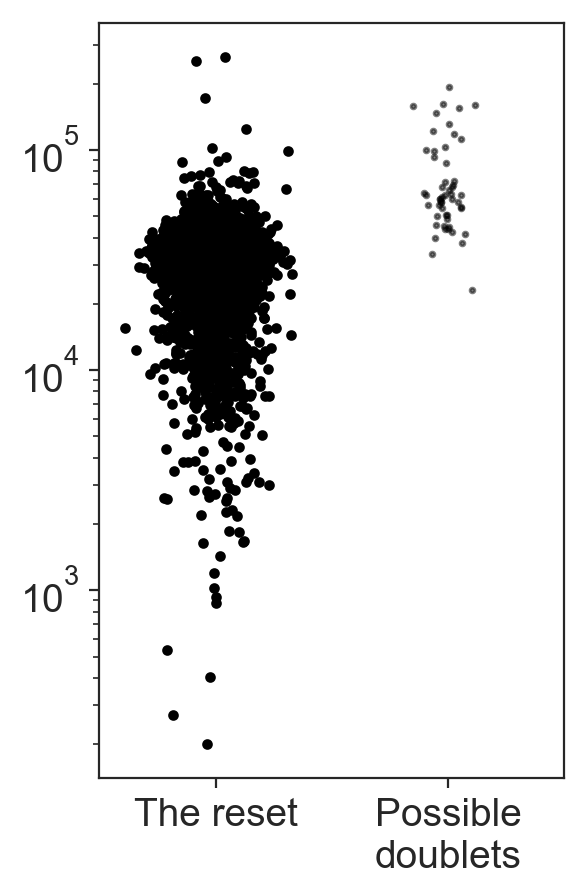

In [57]:
# some cells showed high counts around both T-cell and B-cell markers
# these are possible doublets
# if this is the case, they might have more reads/fragments than the others

tcf7_high = marker_sum.columns[marker_sum.loc['Tcf7'] > 10]
ebf1_high = marker_sum.columns[marker_sum.loc['Ebf1'] > 10]
bcl11a_high = marker_sum.columns[marker_sum.loc['Bcl11a'] > 10]
bcl11b_high = marker_sum.columns[marker_sum.loc['Bcl11b'] > 10]

dbs1 = (set(tcf7_high) & set(ebf1_high))
dbs2 = (set(bcl11a_high) & set(bcl11b_high))
dbs = dbs1 | dbs2

fig, ax = plt.subplots(figsize=(3,5))

offset1 = np.random.normal(scale=0.1, size=plate_qc.drop(labels=dbs).shape[0])
ax.scatter(1 + offset1, plate_qc.drop(labels=dbs).uniq_frags, s=8, c='k')

offset2 = np.random.normal(scale=0.05, size=len(dbs))
ax.scatter(2 + offset2, plate_qc.loc[dbs].uniq_frags, s=3, c='k', alpha=.5)
ax.set_yscale('log')

ax.set_xticks(range(1,3))
ax.set_xticklabels(['The reset', 'Possible\ndoublets'])
ax.set_xlim(0.5,2.5)

In [58]:
len(dbs)

53

In [59]:
# plate_qc.loc[dbs].to_csv('mSp_scATAC-seq/qc_possible_doublets.csv')

In [60]:
plate_qc.drop(labels=dbs, inplace=True)

# Generate some other experimental figures

In [7]:
# get the size - migration time of the ladder from bioanalzyer trace

ladder_info = pd.read_csv('bioanalyzer_results/Ladder.csv', encoding = 'ISO-8859-1')
ladder_info.head(2)

Size [bp]  Conc. [pg/µl] Molarity [pmol/l]  Observations   Area  \
0        35            125          5,411.30  Lower Marker  160.3   
1        50            150          4,545.50   Ladder Peak  210.2   

   Aligned Migration Time [s]  Peak Height  Peak Width  % of Total  \
0                       43.00         98.1         1.1           0   
1                       45.31        139.0         1.8           0   

   Time corrected area  
0                160.3  
1                210.2

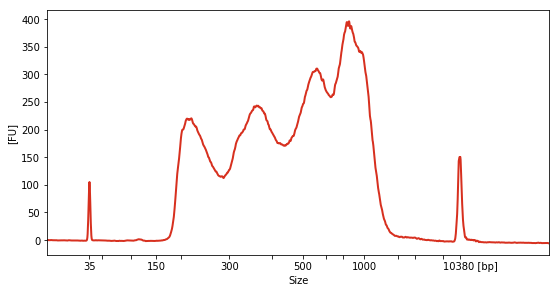

In [8]:
# plot bioanlayzer traces of each library

fig, ax = plt.subplots(figsize=(9,4.5))

samples = iglob('bioanalyzer_results/Rep*.csv')

for s in samples:
    ax.cla()
    sn = s.split('/')[-1][:-4]
    df = pd.read_csv(s, skiprows=17)
    df = df.iloc[:-1,:]
    df = df.astype(float)
    ax.plot(df.Time, df.Value, color='#d7301f', lw=2.)
    ax.set_xticks(ladder_info['Aligned Migration Time [s]'])
    ax.set_xticklabels(['35', '', '', '150', '', '300', '', '500', '', '',
                        '1000', '', '', '', '       10380 [bp]'])
    ax.set_xlim(35, 130)
    ax.set_xlabel("Size")
    ax.set_ylabel('[FU]')
    plt.savefig('figures/{}_bioanlayzer.pdf'.format(sn), bbox_inches='tight', transparent=True)

# Not used in the paper anymore: Comparing downsampled plate scATAC-seq with C1 scATAC-seq

In [20]:
# it seems the sequencing depth of C1 scATAC is about 20% of our plate scATAC
# so here 20% of downsampled of our data is used
qcs = iglob('cmp_to_buenrostro_c1/qc_metrics/*.txt')

dfs = []
for qc in qcs:
    dfs.append(pd.read_table(qc, index_col=0))

ds_plate_qc = pd.concat(dfs, axis=1)
ds_plate_qc['plate'] = ds_plate_qc.index.str.extract('mSp_(.*)_.*', expand=False)
ds_plate_qc['batch'] = ds_plate_qc.plate.replace(batches) 

ds_plate_qc.head(2)

dup_level  frac_open      frip  library_size  mapping_rate  \
cell                                                                        
mSp_rep10_001   0.774630   0.165905  0.737259       29665.0         97.05   
mSp_rep10_002   0.784939   0.202633  0.676183       41291.0         96.44   

               mt_content  sequencing_depth  uniq_frags  plate          batch  
cell                                                                           
mSp_rep10_001    0.008944            140871     29033.0  rep10  Sp#2 (n=2688)  
mSp_rep10_002    0.023460            210428     39919.0  rep10  Sp#2 (n=2688)

In [21]:
ds_plate_qc.median()

dup_level                0.770263
frac_open                0.156997
frip                     0.733419
library_size         27727.000000
mapping_rate            97.050000
mt_content               0.019173
sequencing_depth    128320.000000
uniq_frags           26448.000000
dtype: float64

In [23]:
qcs = iglob('buenrostro_c1/qc_metrics/*.txt')

dfs = []
for qc in qcs:
    dfs.append(pd.read_table(qc, index_col=0))

c1_qc = pd.concat(dfs, axis=1)

annotation = pd.concat([pd.read_table('buenrostro_c1/PRJNA274006.txt'),
                        pd.read_table('buenrostro_c1/PRJNA299657.txt')])

c1_qc.rename(index=dict(annotation[['run_accession', 'sample_title']].values),
             inplace=True)
c1_qc['cells'] = c1_qc.index.str.split('-').str[1]
c1_qc['batch'] = c1_qc.index.str.extract('singles-(.*)-.*-.*', expand=False)

# one sample is not captured with str.extract
c1_qc['batch'].fillna('BM1077-LMPP', inplace=True)

# add number of cells into batch name
n = c1_qc['batch'].value_counts()
rebatch = {}
for i in n.index:
    rebatch[i] = str(i) + ' (n=%s)' % str(n[i])
c1_qc.replace({'batch' : rebatch}, inplace=True)

In [24]:
c1_qc.median()

dup_level                0.612317
frac_open                0.067088
frip                     0.554559
library_size         30334.000000
mapping_rate            69.775000
mt_content               0.536170
sequencing_depth    134669.000000
uniq_frags            8647.500000
dtype: float64

In [25]:
c1_qc.batch.value_counts()

K562-rep2 (n=192)      192
SU070 (n=192)          192
K562-rep3 (n=192)      192
K562-rep1 (n=192)      192
BJ (n=96)               96
K562-JNKi (n=96)        96
mESC (n=96)             96
HL60 (n=96)             96
K562-Imat1hr (n=96)     96
GM-rep4 (n=96)          96
H1ESC (n=96)            96
GM-rep3 (n=96)          96
GM-rep1 (n=96)          96
PB1022-mono (n=96)      96
EML (n=96)              96
GM-rep2 (n=96)          96
GM-TNFa6h (n=96)        96
K562-CDKi (n=96)        96
TF1 (n=96)              96
SU353-Blast (n=96)      96
SU353-LSC (n=96)        96
BM1077-LMPP (n=96)      96
Name: batch, dtype: int64

In [27]:
sample_info = pd.concat([ds_plate_qc, c1_qc], sort=False)
sample_info.head(2)

dup_level  frac_open      frip  library_size  mapping_rate  \
cell                                                                        
mSp_rep10_001   0.774630   0.165905  0.737259       29665.0         97.05   
mSp_rep10_002   0.784939   0.202633  0.676183       41291.0         96.44   

               mt_content  sequencing_depth  uniq_frags  plate          batch  \
cell                                                                            
mSp_rep10_001    0.008944            140871     29033.0  rep10  Sp#2 (n=2688)   
mSp_rep10_002    0.023460            210428     39919.0  rep10  Sp#2 (n=2688)   

              cells  
cell                 
mSp_rep10_001   NaN  
mSp_rep10_002   NaN

In [28]:
median_info = sample_info.groupby("batch").median()

# call drop_duplicates on sample_info to re-order the experiments
median_info = median_info.loc[sample_info.batch.drop_duplicates().values,]
reorder = [1, 0] + list(range(2,24))
median_info = median_info.iloc[reorder,]
median_info.head(2)

dup_level  frac_open      frip  library_size  mapping_rate  \
batch                                                                       
Sp#1 (n=960)    0.802241   0.155556  0.733978       27425.0        97.165   
Sp#2 (n=2688)   0.760225   0.157420  0.733321       27821.0        97.010   

               mt_content  sequencing_depth  uniq_frags  
batch                                                    
Sp#1 (n=960)     0.021380          148639.0     26593.5  
Sp#2 (n=2688)    0.018632          122675.5     26426.5

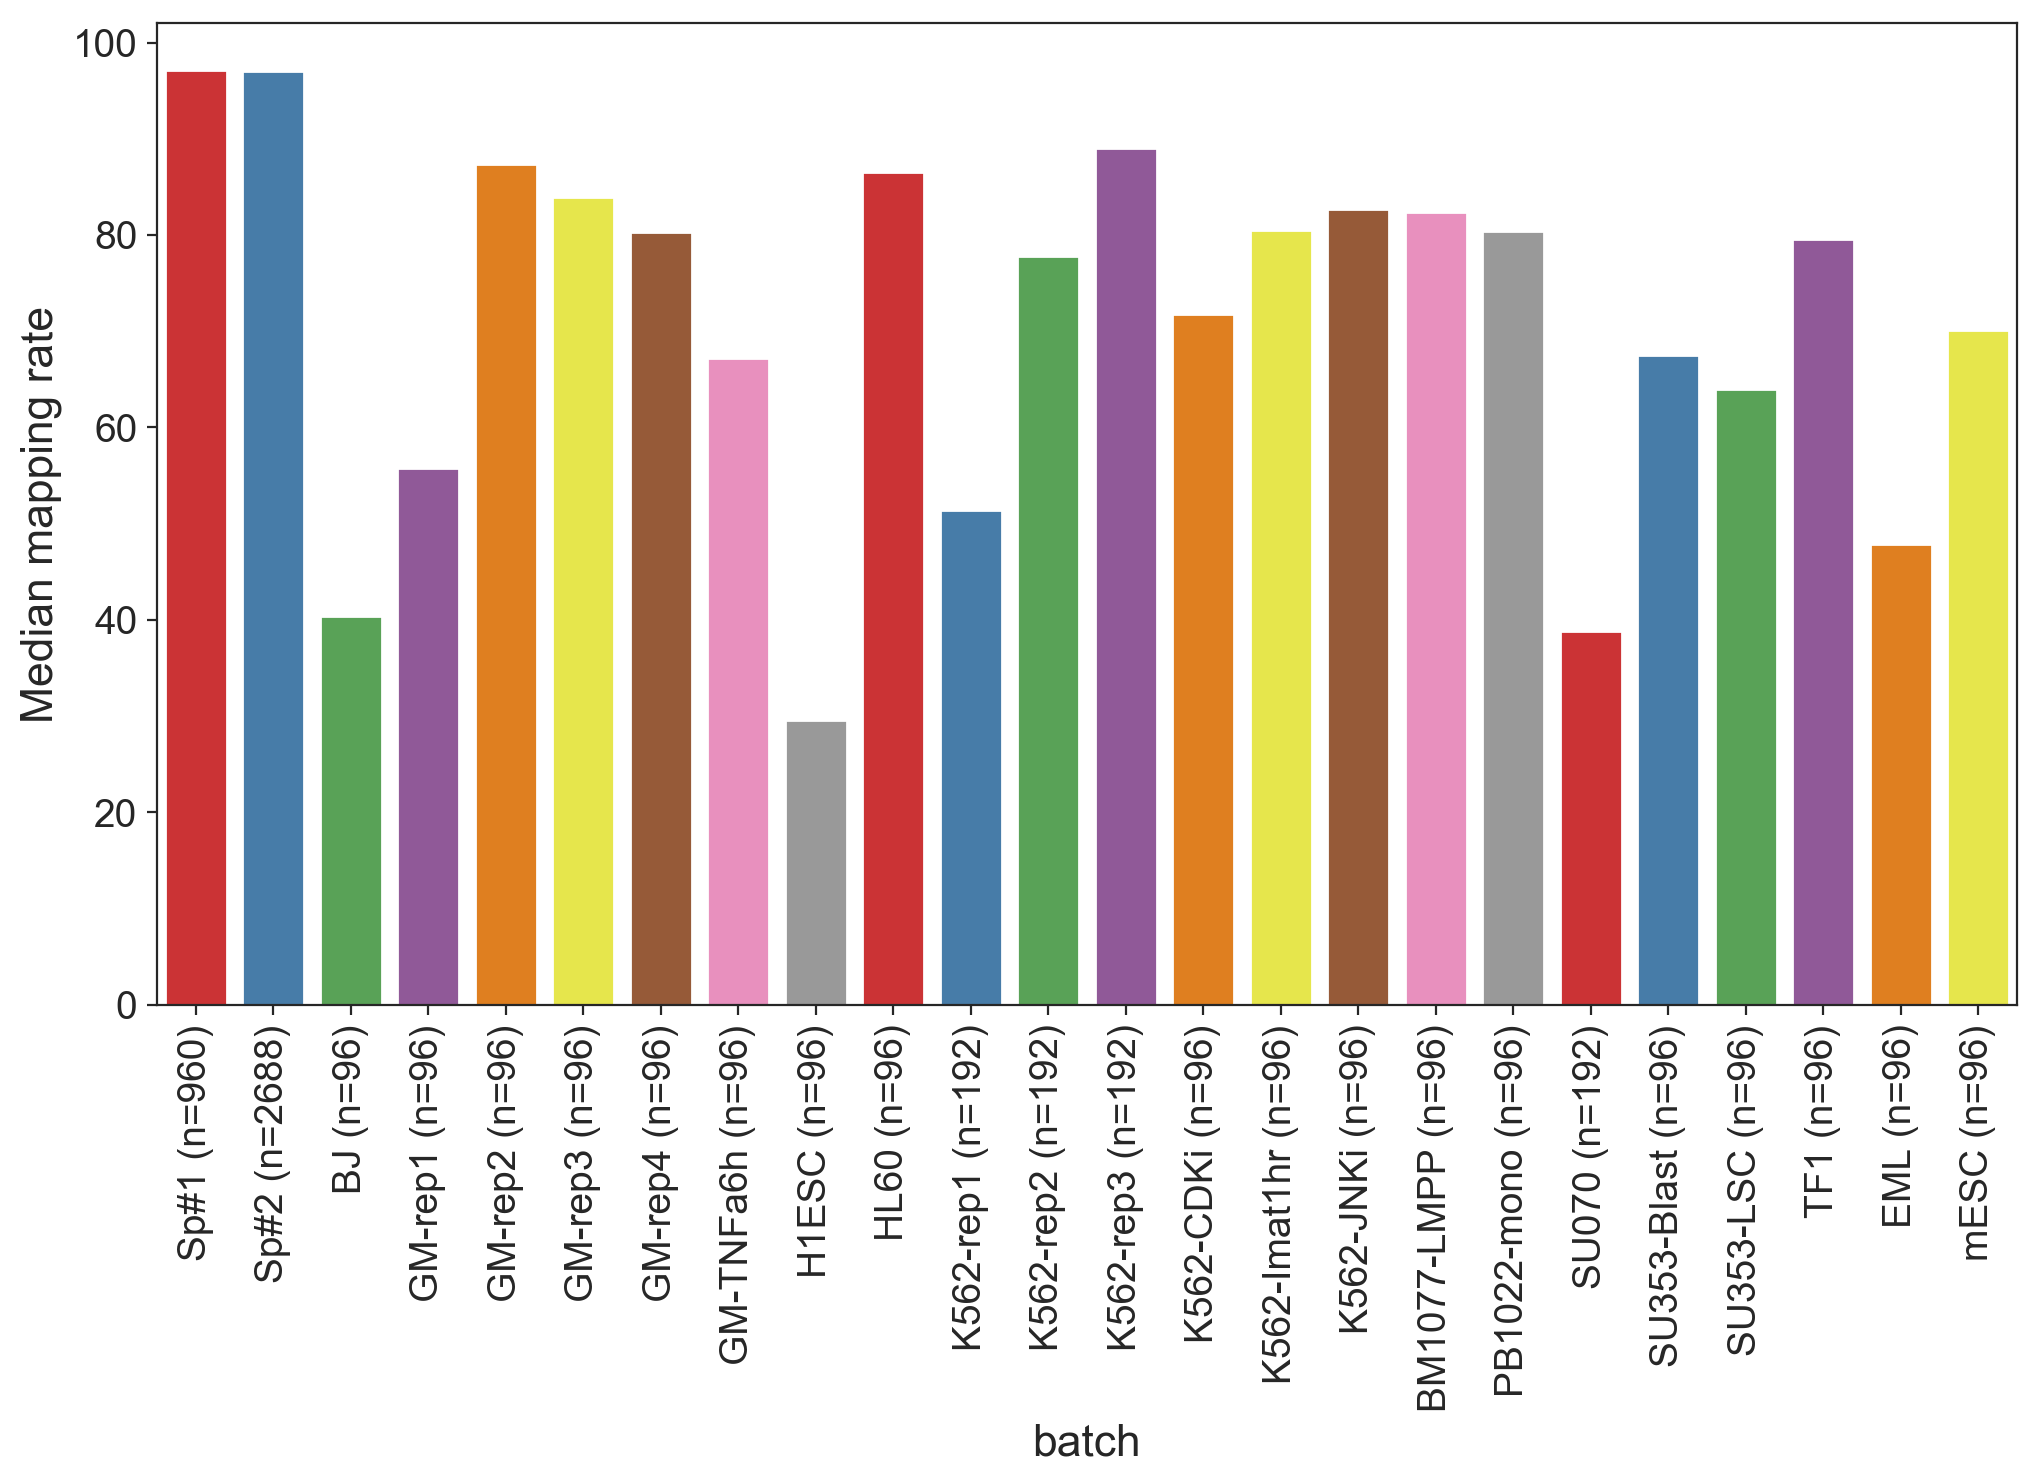

In [29]:
fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(x=median_info.index, y="mapping_rate", data=median_info, palette="Set1", ax=ax)
ax.set_ylabel("Median mapping rate")
for xt in ax.get_xticklabels():
    xt.set_rotation(90)
# plt.savefig("figures/compare_mapping_rate.pdf", bbox_inches="tight", transparent=True)

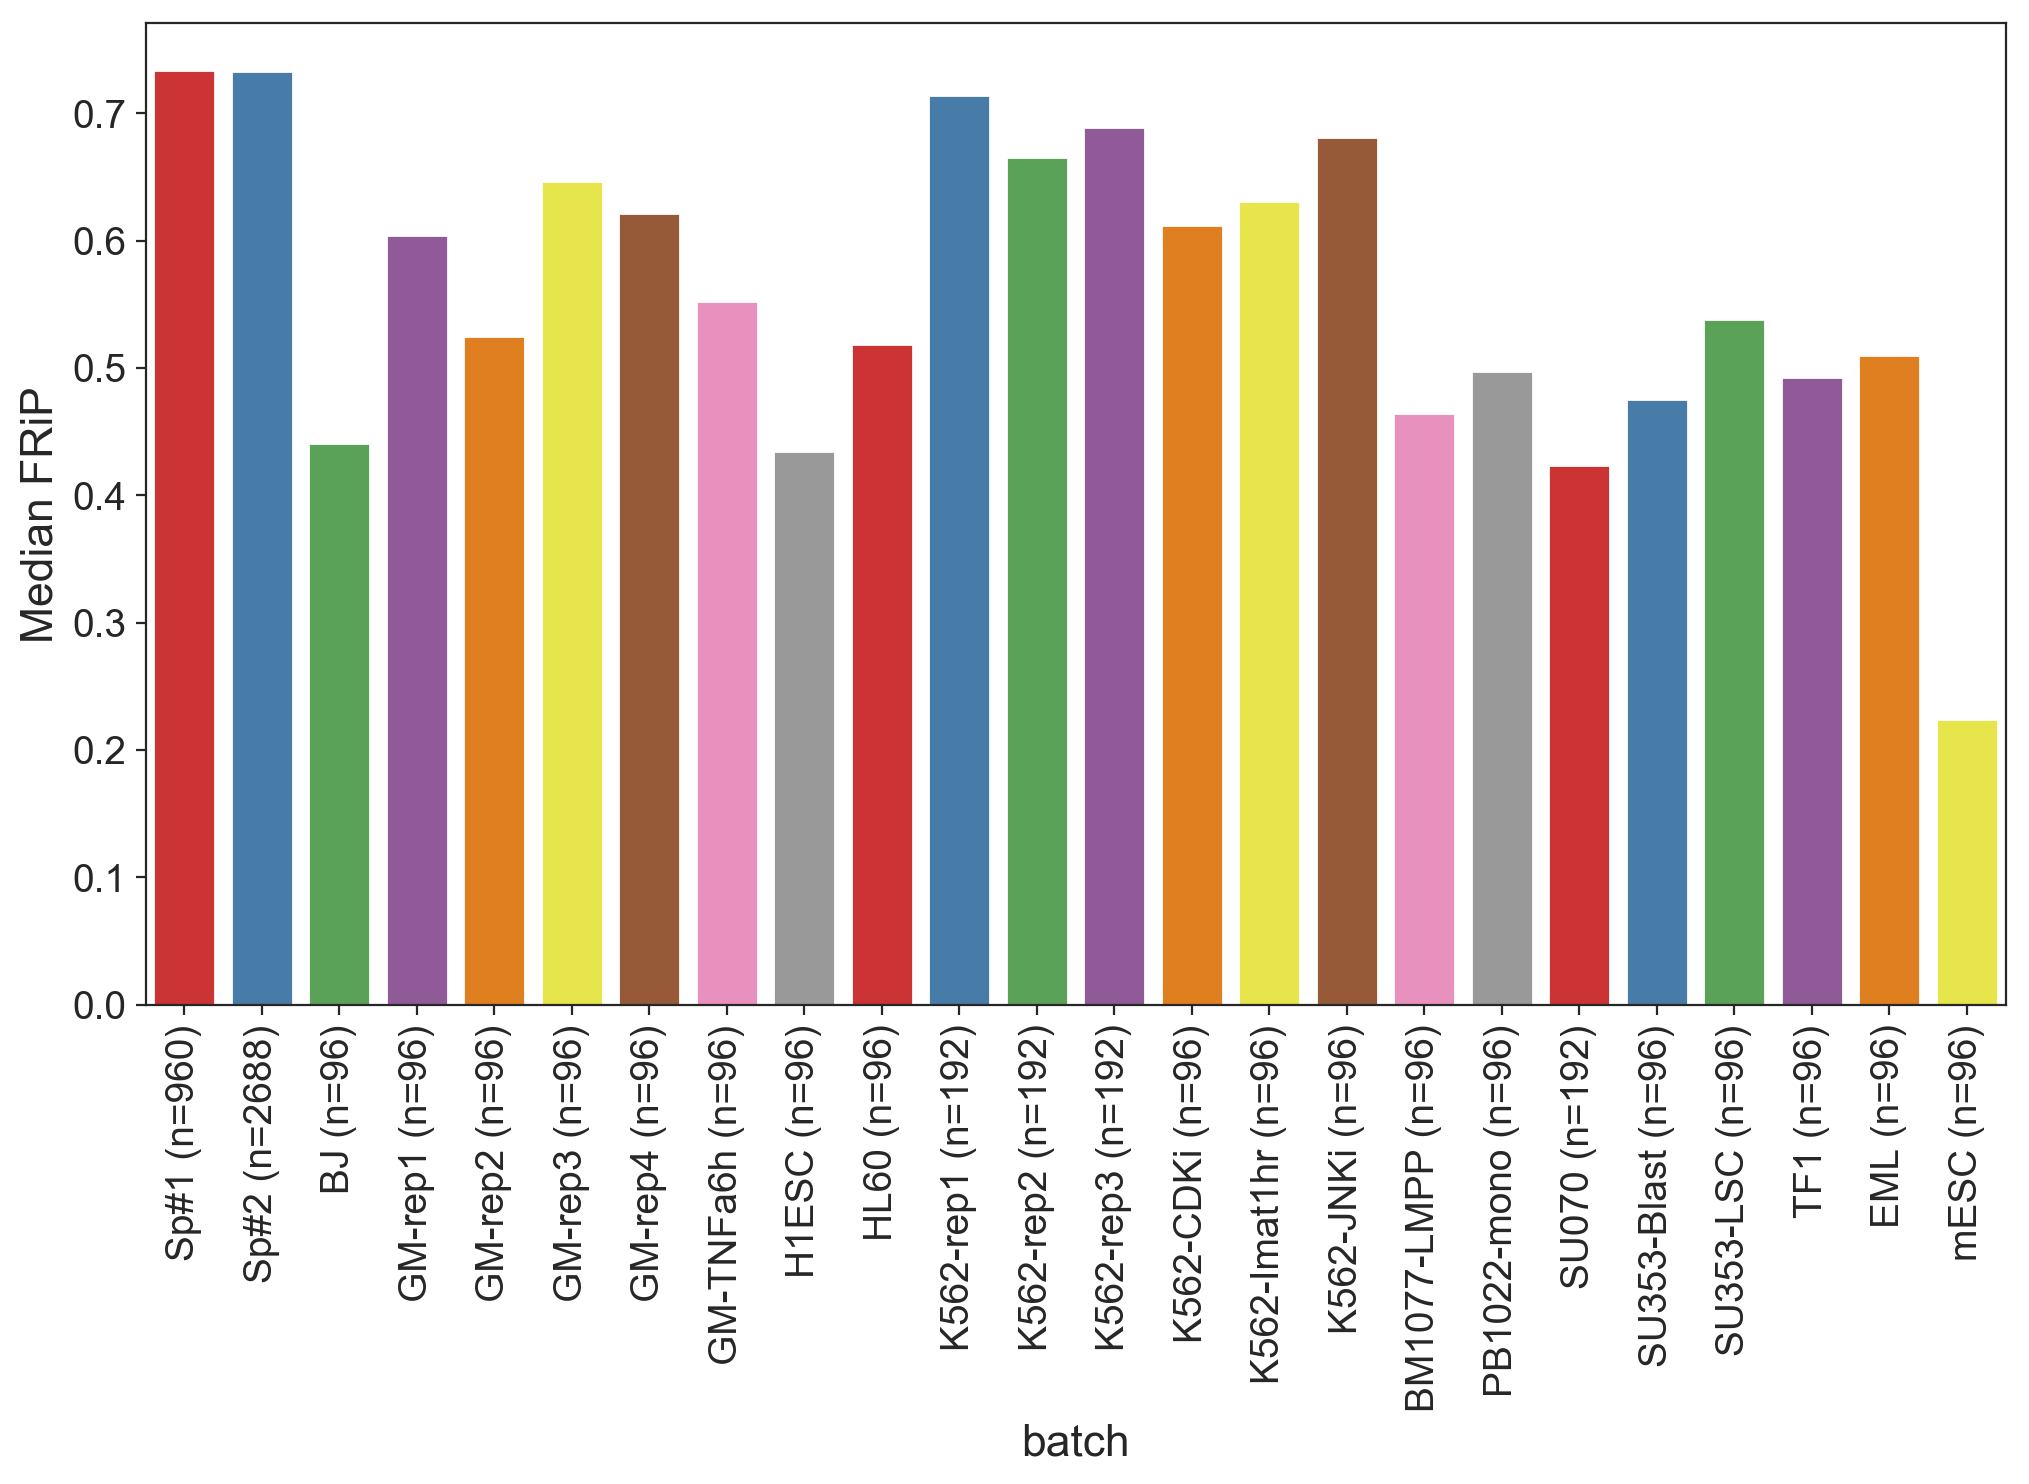

In [30]:
fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(x=median_info.index, y='frip', data=median_info, palette='Set1', ax=ax)
ax.set_ylabel('Median FRiP')
for xt in ax.get_xticklabels():
    xt.set_rotation(90)
# plt.savefig('figures/compare_frip.pdf', bbox_inches='tight', transparent=True)

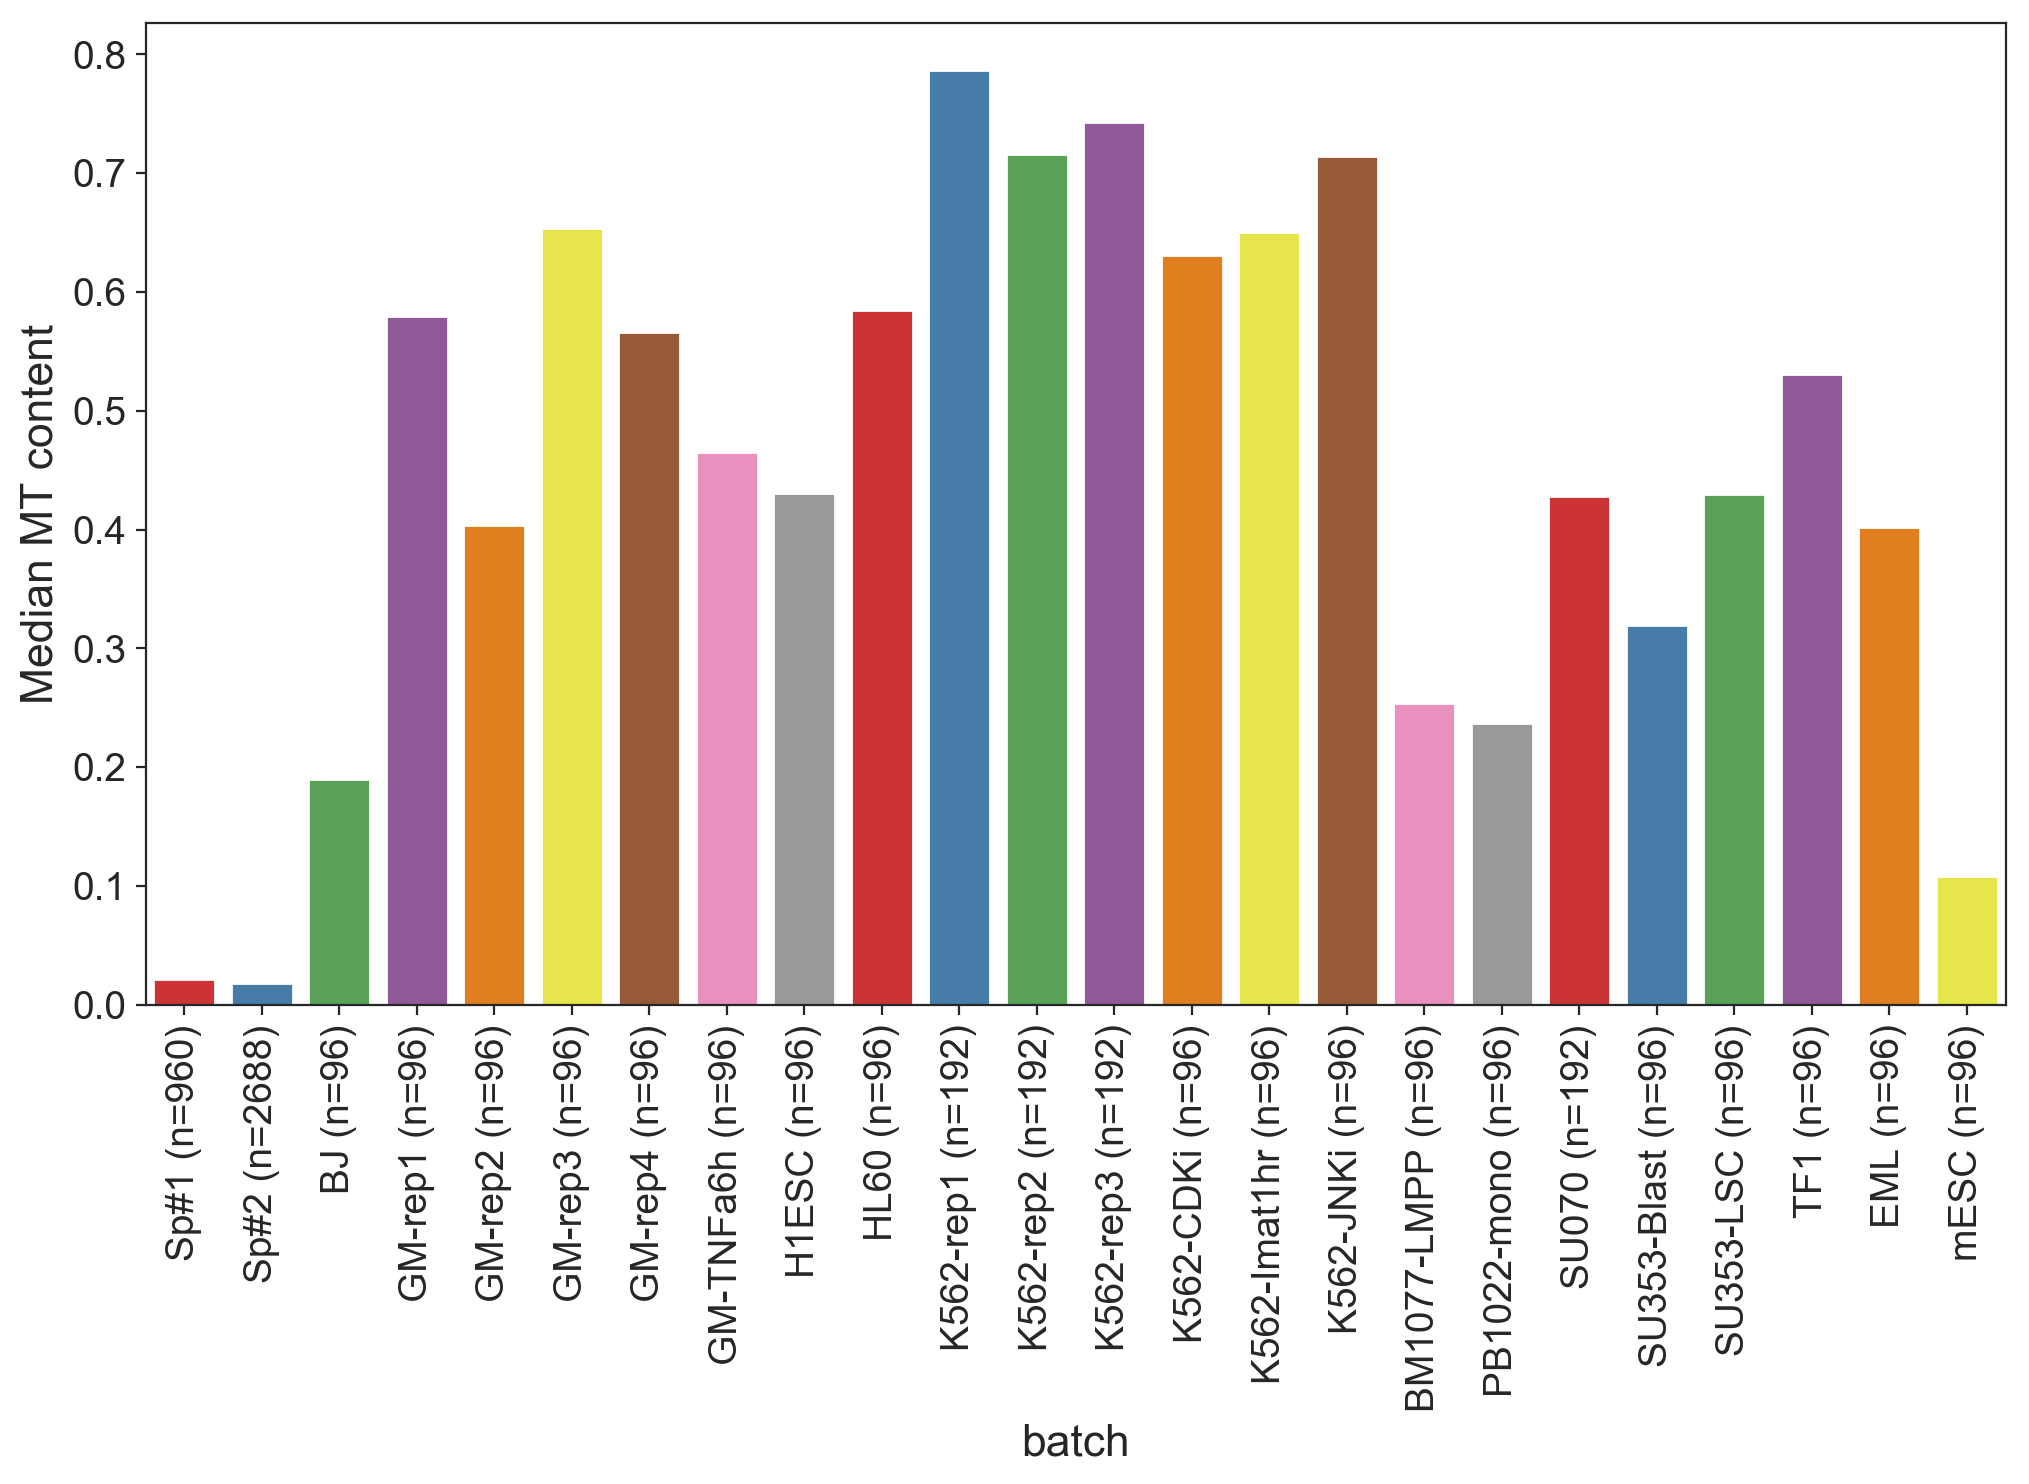

In [31]:
# this is not a entirely fair comparison since we used digitonin in this study
# while the C1 studies were using NP-40

fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(x=median_info.index, y='mt_content', data=median_info, palette='Set1', ax=ax)
ax.set_ylabel('Median MT content')
for xt in ax.get_xticklabels():
    xt.set_rotation(90)
# plt.savefig('figures/compare_mt_content.pdf', bbox_inches='tight', transparent=True)

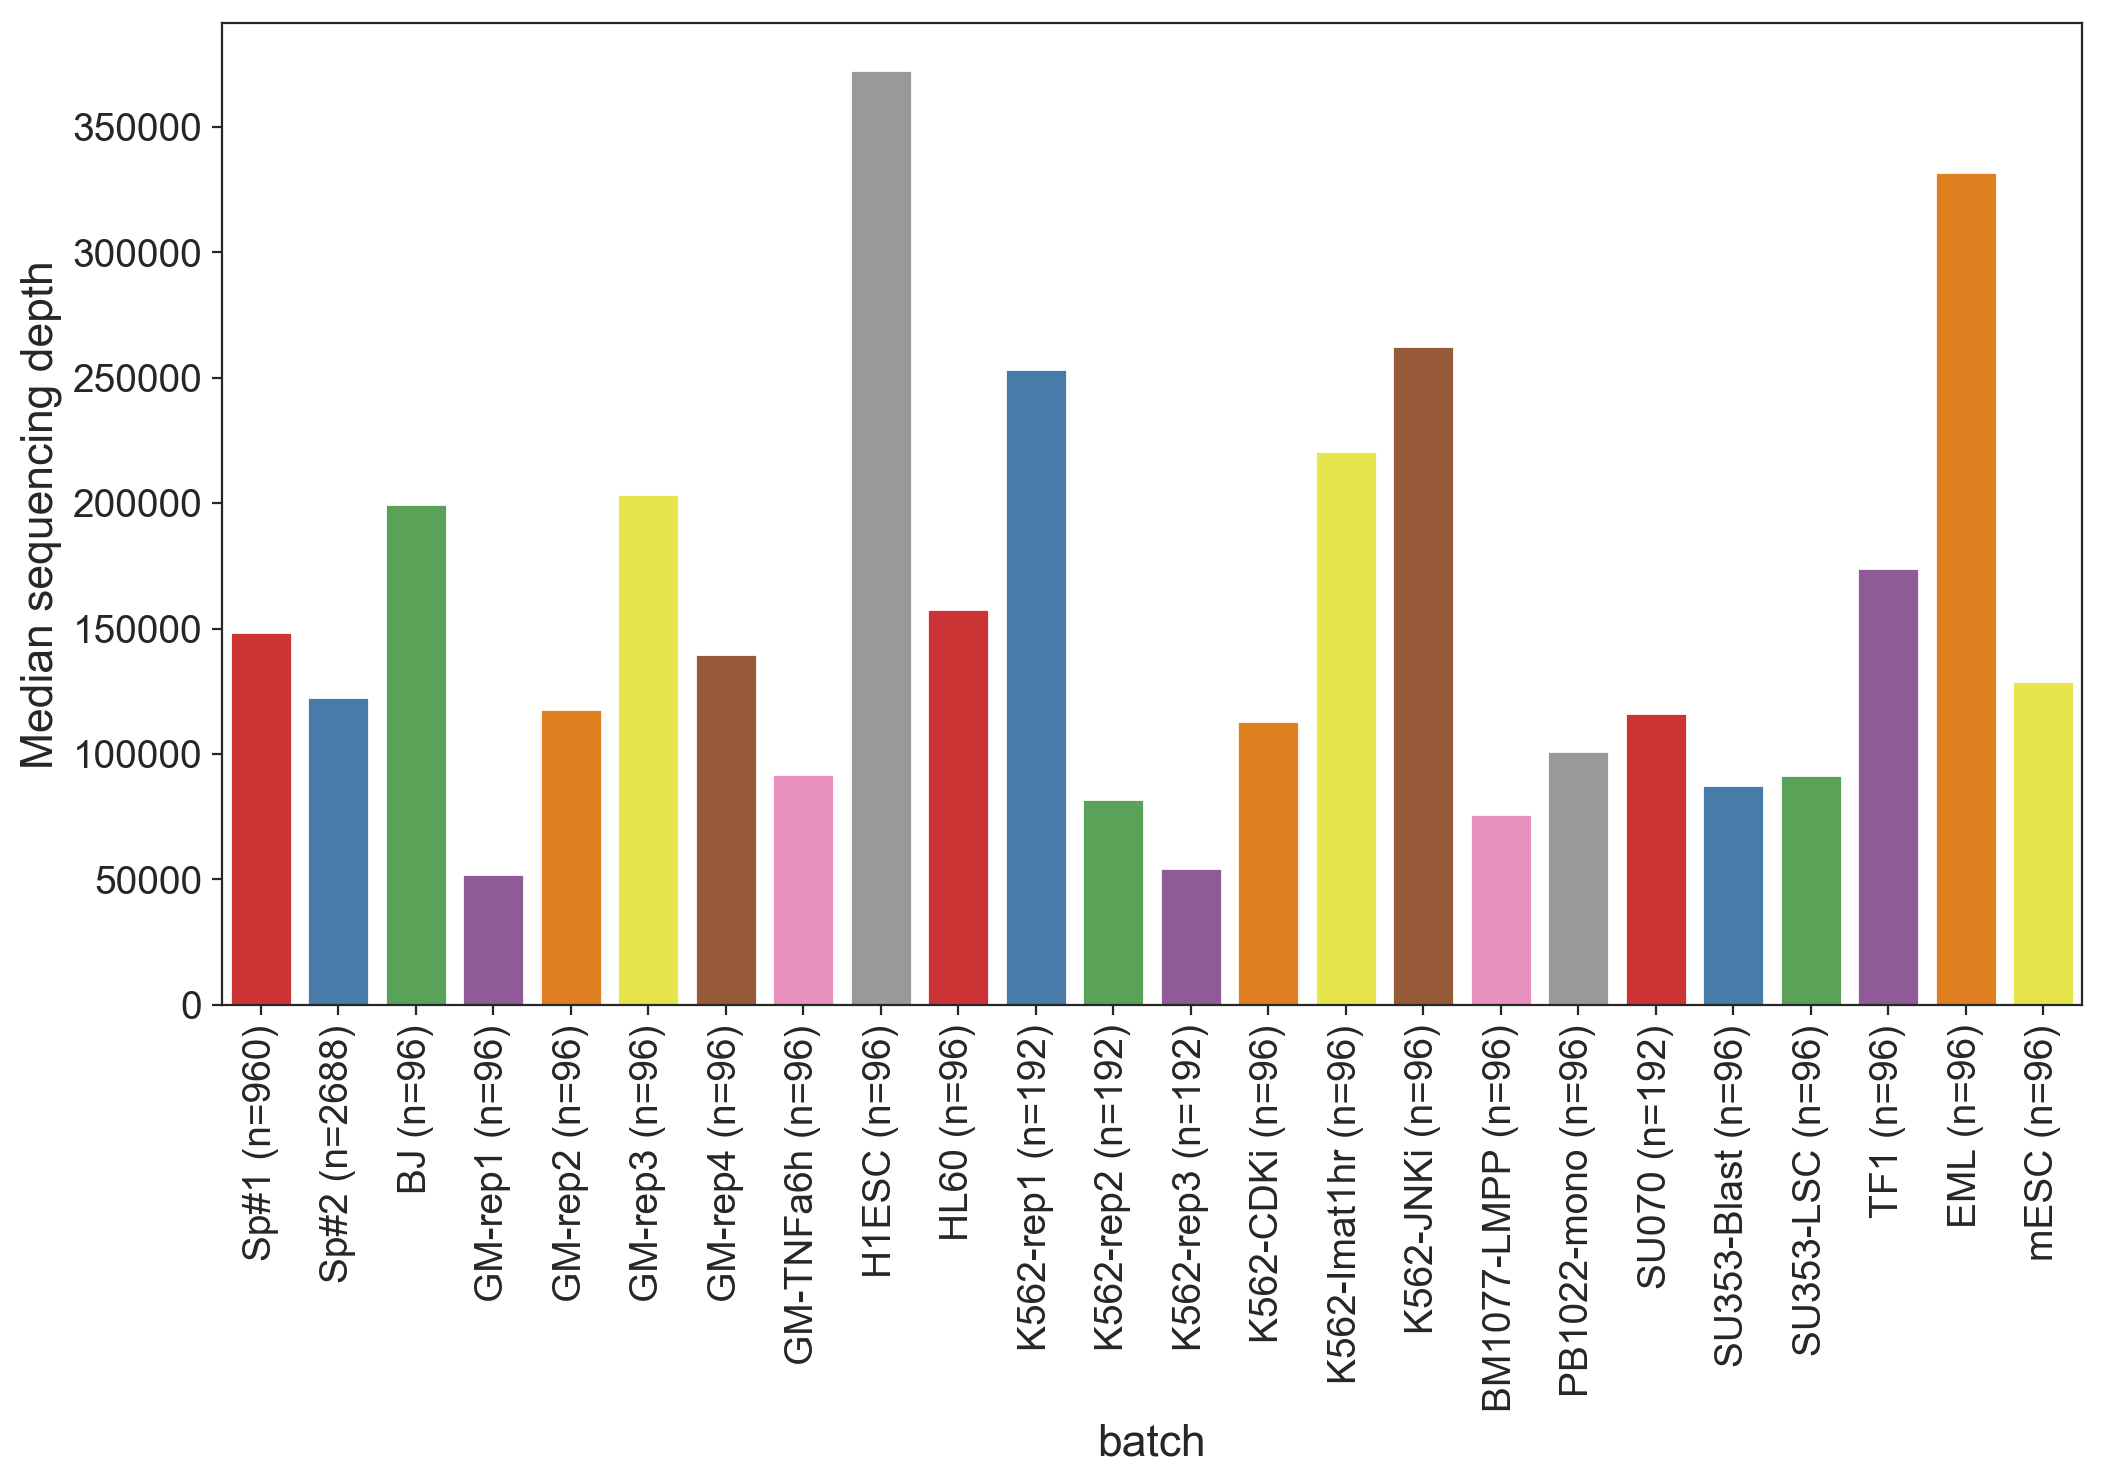

In [32]:
fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(x=median_info.index, y='sequencing_depth', data=median_info, palette='Set1', ax=ax)
ax.set_ylabel('Median sequencing depth')
for xt in ax.get_xticklabels():
    xt.set_rotation(90)
# plt.savefig('figures/compare_sequencing_depth.pdf', bbox_inches='tight', transparent=True)

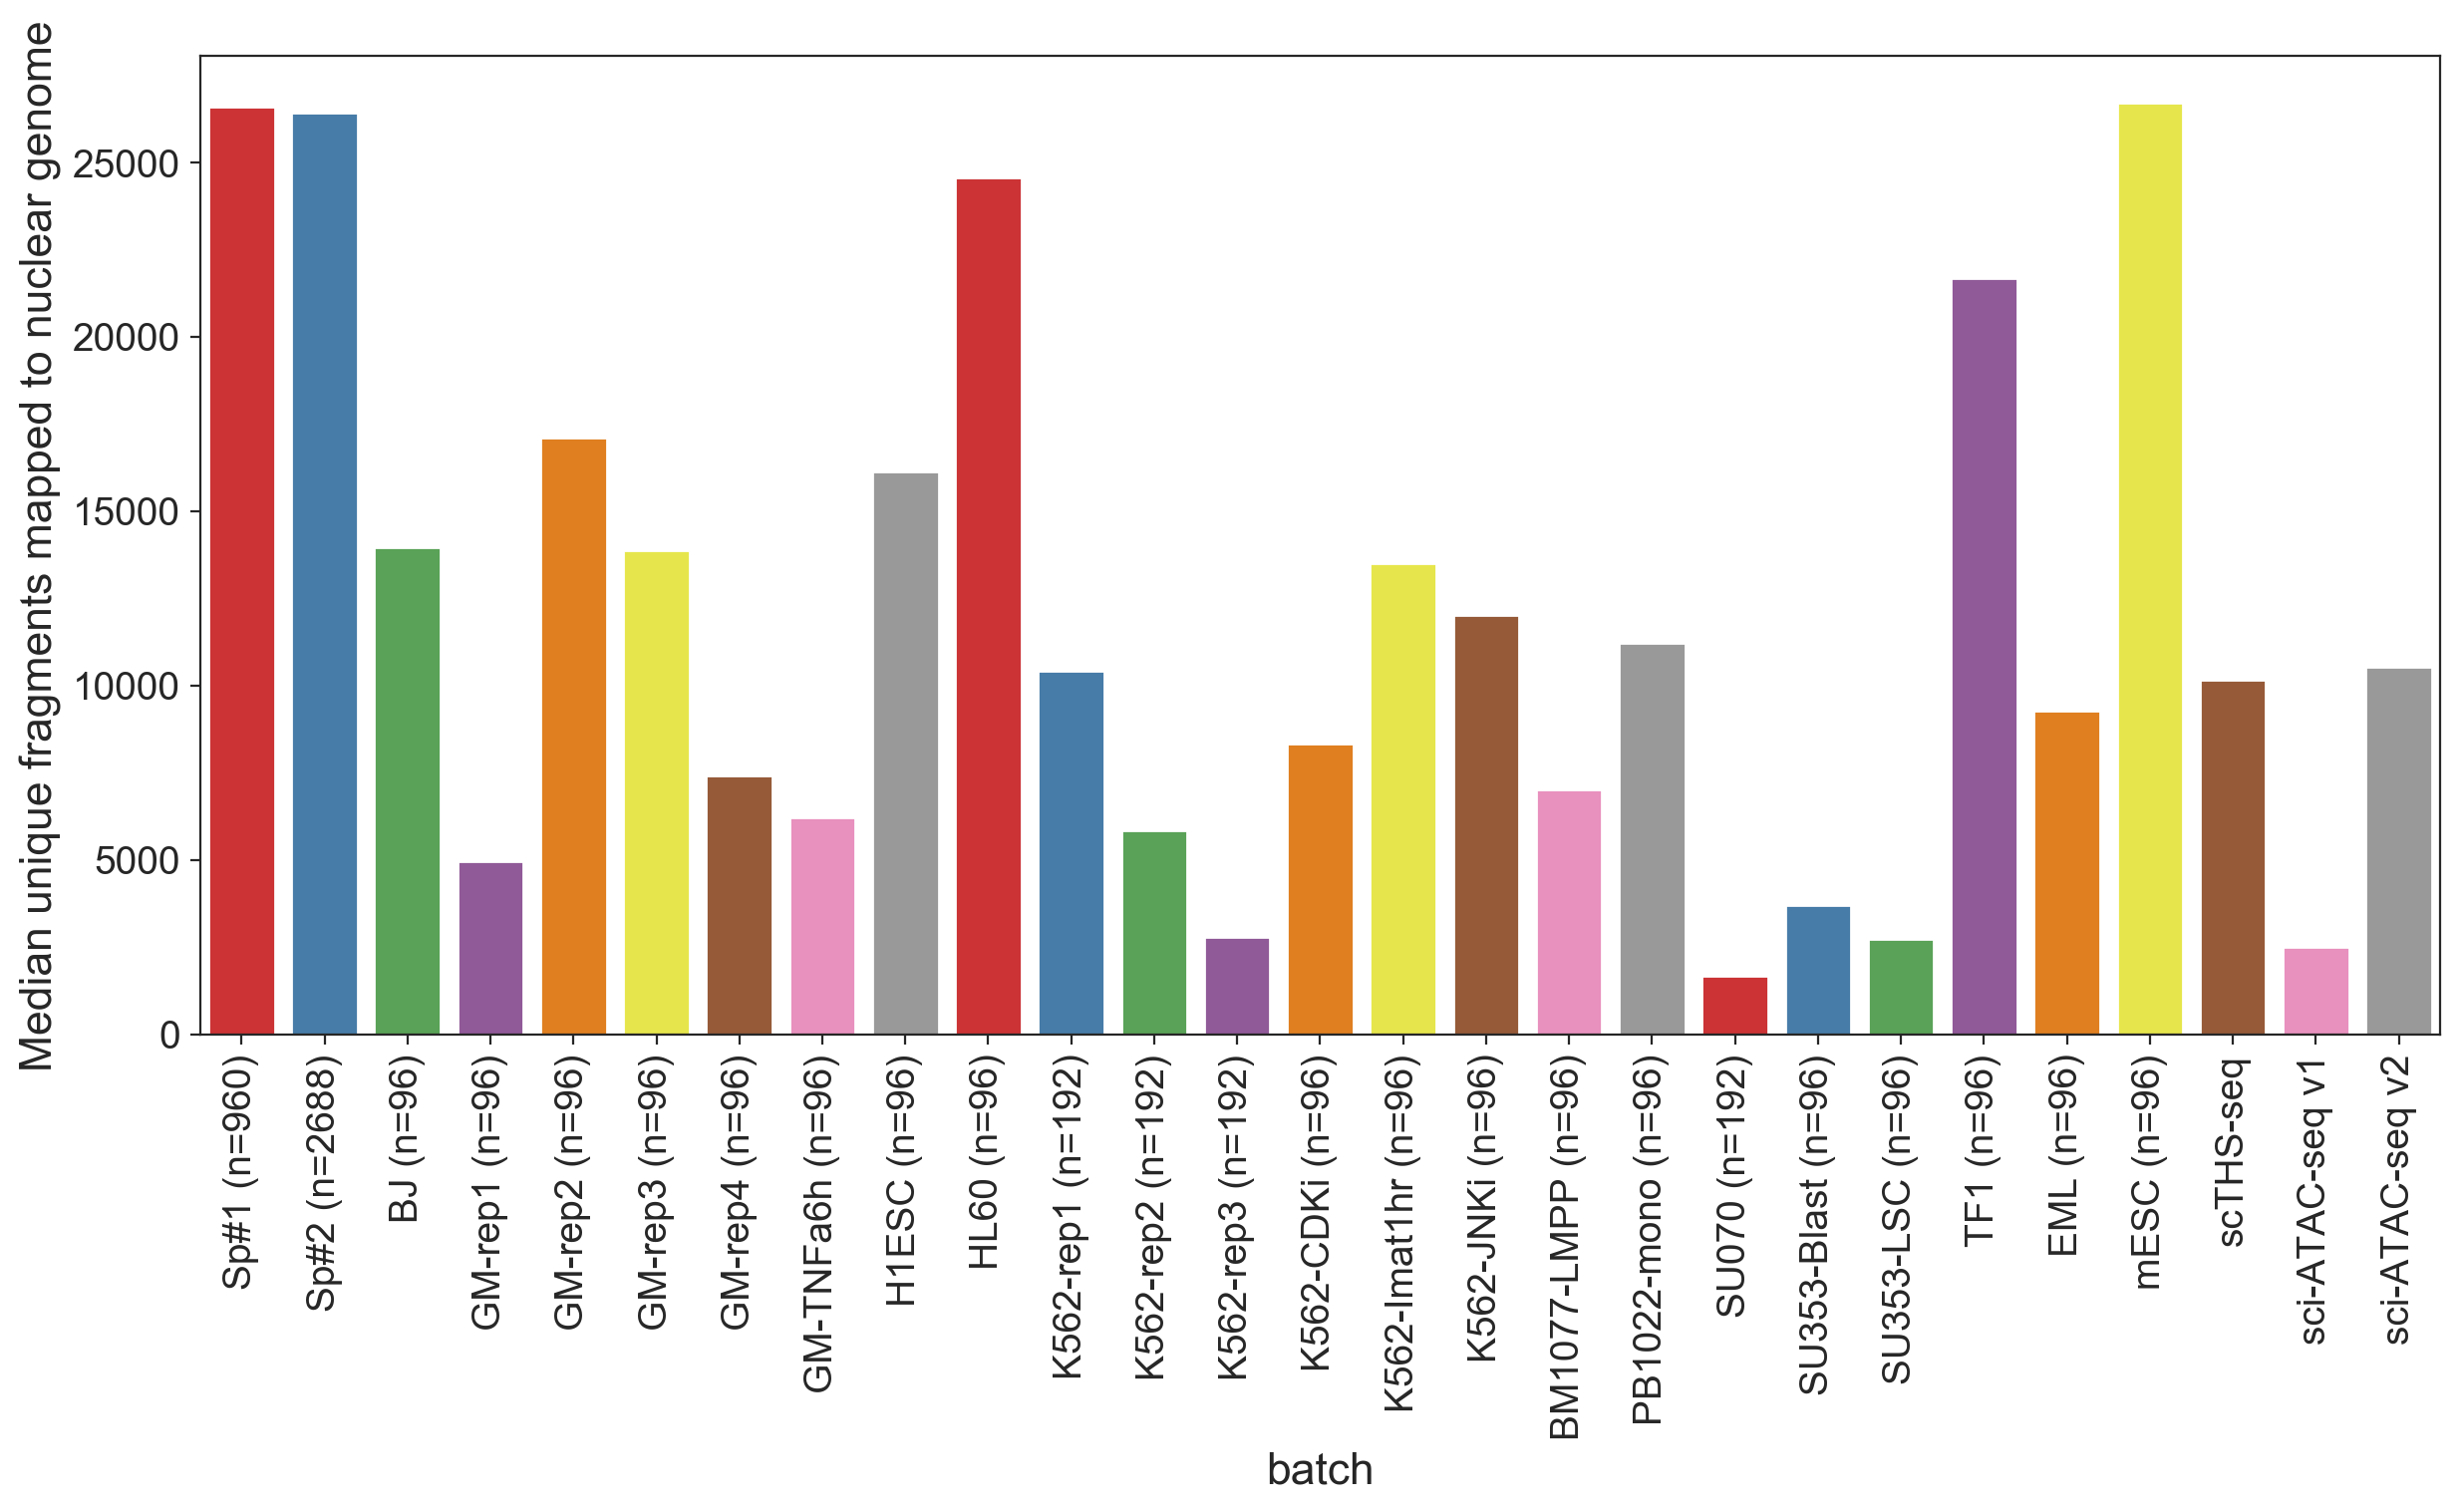

In [33]:
# add information of scTHS-seq (Lake et al. 2018 Nature Biotechnology 36, 70–80.)
# & sci-ATAC-seq v1 (Cusanovich et al. 2015 Science 348: 910–914.)
# & sci-ATAC-seq v2 (Cusanovich et al. 2017 doi: https://doi.org/10.1101/166066)

median_info.loc['scTHS-seq','uniq_frags'] = 10168
median_info.loc['sci-ATAC-seq v1', 'uniq_frags'] = 2503
median_info.loc['sci-ATAC-seq v2', 'uniq_frags'] = 10540

fig, ax = plt.subplots(figsize=(14.5, 6.5))

sns.barplot(x=median_info.index, y='uniq_frags', data=median_info, palette='Set1', ax=ax)
ax.set_ylabel('Median unique fragments mapped to nuclear genome')
for xt in ax.get_xticklabels():
    xt.set_rotation(90)
# plt.savefig('figures/compare_uniq_frags.pdf',
#             bbox_inches='tight', transparent=True)

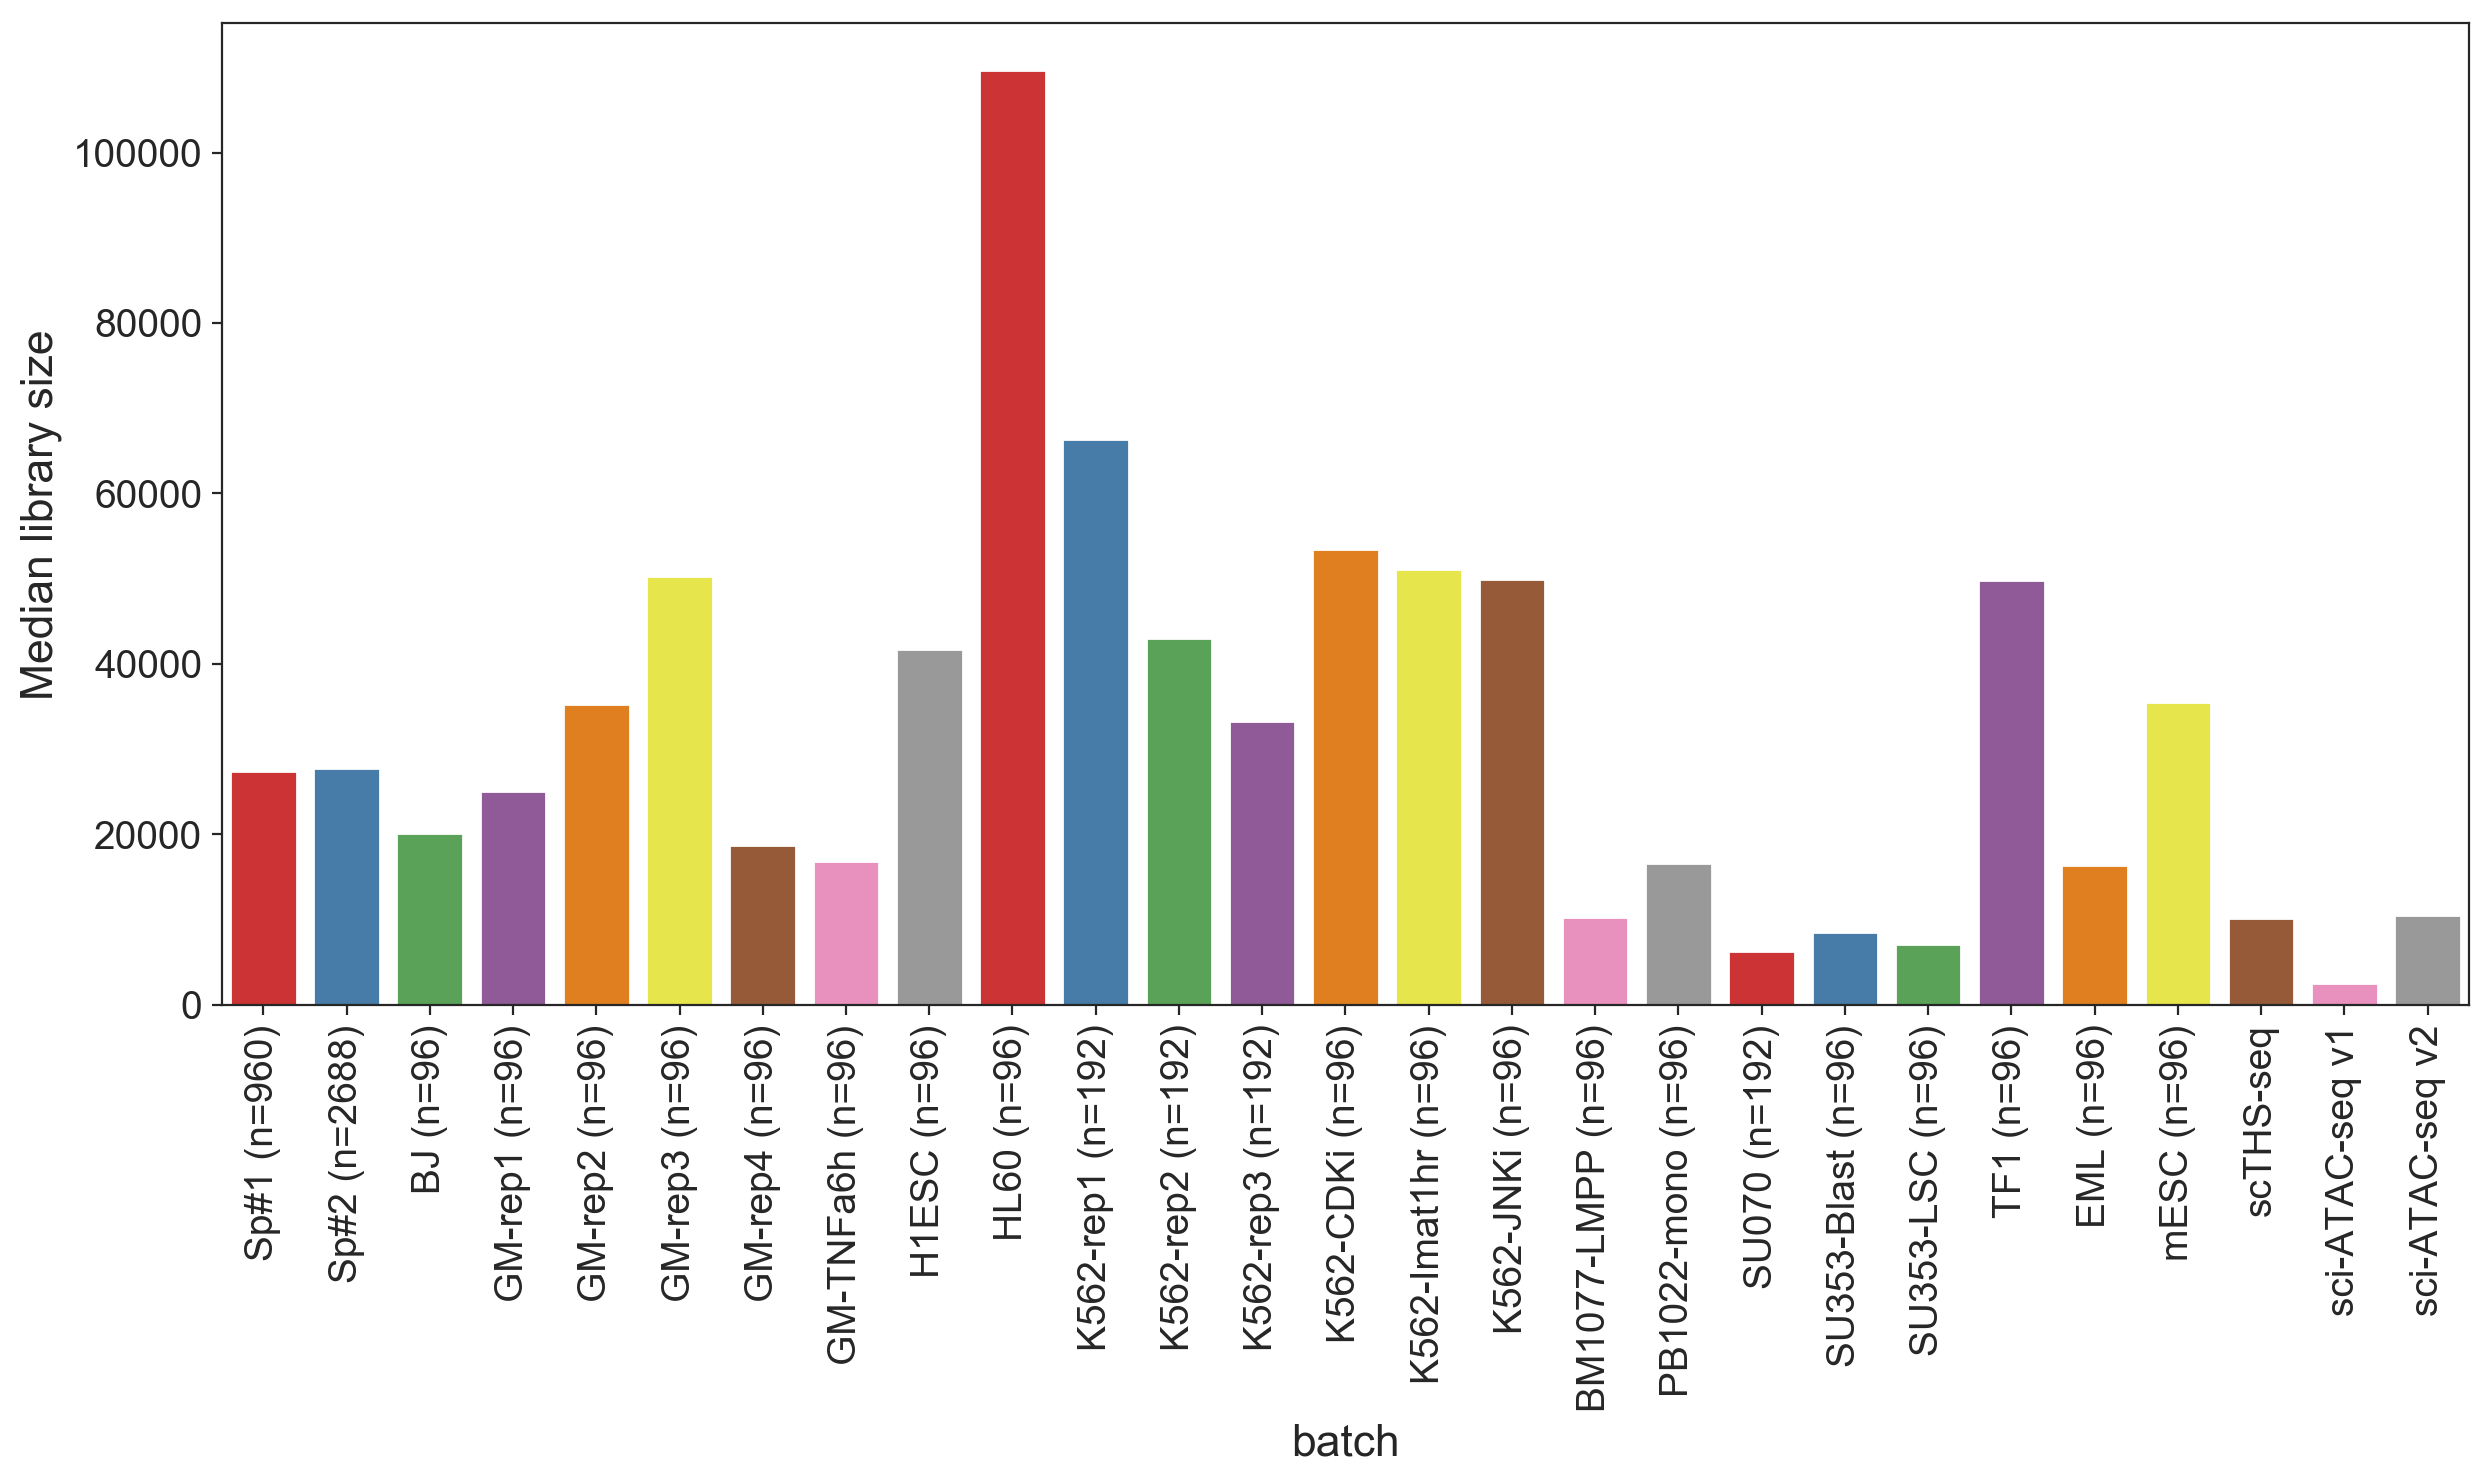

In [34]:
# add information of scTHS-seq (Lake et al. 2018 Nature Biotechnology 36, 70–80.)
# & sci-ATAC-seq v1 (Cusanovich et al. 2015 Science 348: 910–914.)
# & sci-ATAC-seq v2 (Cusanovich et al. 2017 doi: https://doi.org/10.1101/166066)

median_info.loc['scTHS-seq','library_size'] = 10168
median_info.loc['sci-ATAC-seq v1', 'library_size'] = 2503
median_info.loc['sci-ATAC-seq v2', 'library_size'] = 10540

fig, ax = plt.subplots(figsize=(14.5, 6.5))

sns.barplot(x=median_info.index, y='library_size', data=median_info, palette='Set1', ax=ax)
ax.set_ylabel('Median library size')
for xt in ax.get_xticklabels():
    xt.set_rotation(90)
# plt.savefig('figures/compare_uniq_frags.pdf',
#             bbox_inches='tight', transparent=True)